In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from gprofiler import GProfiler

# scTRS tools
import scTRS.util as util
import scTRS.data_loader as dl
import scTRS.method as md

# autoreload
%load_ext autoreload
%autoreload 2
# logging
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.19.0 scipy==1.5.1 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1


In [2]:
# Setup file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data'
# Please change this to your own path
RESULT_PATH = '/n/home11/mjzhang/gwas_informed_scRNAseq/results'

### Load TMS data 

In [3]:
# Count data (used for scoring genes)
start_time = time.time()
data_facs_ct = dl.load_tms_ct(DATA_PATH, data_name='facs')
print('# TMS facs count data: n_cell=%d, n_gene=%d'
      %(data_facs_ct.shape[0], data_facs_ct.shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

Trying to set attribute `.obs` of view, copying.


# TMS facs count data: n_cell=110096, n_gene=22966
# time=15.3s


In [4]:
# Processed data from TMS official release
start_time = time.time()
dic_data_facs = dl.load_tms_processed(DATA_PATH, data_name='facs', tissue='all')
for tissue in dic_data_facs.keys():
    print('# TMS facs %s: n_cell=%d, n_gene=%d'
          %(tissue, dic_data_facs[tissue].shape[0], dic_data_facs[tissue].shape[1]))
print('# time=%0.1fs'%(time.time() - start_time))

# load_tms_processed: load facs data, tissue=[Aorta, BAT, Bladder, Brain_Myeloid, Brain_Non-Myeloid, Diaphragm, GAT, Heart, Kidney, Large_Intestine, Limb_Muscle, Liver, Lung, MAT, Mammary_Gland, Marrow, Pancreas, SCAT, Skin, Spleen, Thymus, Tongue, Trachea]


/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/n/home11/mjzhang/myenv/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


# TMS facs Aorta: n_cell=906, n_gene=22966
# TMS facs BAT: n_cell=2223, n_gene=22966
# TMS facs Bladder: n_cell=2432, n_gene=22966
# TMS facs Brain_Myeloid: n_cell=13417, n_gene=22966
# TMS facs Brain_Non-Myeloid: n_cell=7249, n_gene=22966
# TMS facs Diaphragm: n_cell=1858, n_gene=22966
# TMS facs GAT: n_cell=3406, n_gene=22966
# TMS facs Heart: n_cell=9669, n_gene=22966
# TMS facs Kidney: n_cell=1833, n_gene=22966
# TMS facs Large_Intestine: n_cell=8311, n_gene=22966
# TMS facs Limb_Muscle: n_cell=3855, n_gene=22966
# TMS facs Liver: n_cell=2859, n_gene=22966
# TMS facs Lung: n_cell=5218, n_gene=22966
# TMS facs MAT: n_cell=3014, n_gene=22966
# TMS facs Mammary_Gland: n_cell=3282, n_gene=22966
# TMS facs Marrow: n_cell=14517, n_gene=22966
# TMS facs Pancreas: n_cell=3384, n_gene=22966
# TMS facs SCAT: n_cell=3755, n_gene=22966
# TMS facs Skin: n_cell=4860, n_gene=22966
# TMS facs Spleen: n_cell=3834, n_gene=22966
# TMS facs Thymus: n_cell=4047, n_gene=22966
# TMS facs Tongue: n_cell=3

### Load gene annotation

In [5]:
# Get 64 independent traits 
df_sumstats_meta = pd.read_excel(DATA_PATH+'/sumstats/Description_080419.xlsx',
                                 sheet_name='64 Recommended indepent traits')
df_sumstats_meta = df_sumstats_meta[['Trait_Identifier', 'h2g', 'Z', 'N']]

In [6]:
# MAGMA gene annotation
df_geneannot = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.txt', sep='\t')
print('# MAGMA annotation: n_gene=%d, n_trait=%d'%(df_geneannot.shape[0], df_geneannot.shape[1]))

# Ortholog genes 
# (computed using following two lines of codes, stored to void dulplicated computation )
# gp = GProfiler(return_dataframe=True)
# df_orth = gp.orth(organism='hsapiens', query=list(df_geneannot.index), target='mmusculus')
df_orth = pd.read_csv(DATA_PATH+'/gene_annotation/Genes_by_X_kushal/Genes_by_X_MAGMA_10kb_Z.orth.txt', sep='\t')

# Use only human genes that can be uniquely mapped to a mouse gene
temp_df = df_orth.groupby(['incoming']).agg({'name':len})
gene_list = list(temp_df.index[temp_df['name']==1])
gene_list.sort()
df_orth.index = df_orth['incoming']
df_orth = df_orth.loc[gene_list]
print('# MAGMA annotation: n_mouse_gene_converted=%d'%(df_orth.shape[0]))

# Change df_geneannot genes to mouse genes
dic_mapping = {df_orth['incoming'].values[x]:df_orth['name'].values[x] for x in np.arange(df_orth.shape[0])}
df_geneannot = df_geneannot.loc[gene_list]
df_geneannot.index = [dic_mapping[x] for x in df_geneannot.index]

# MAGMA annotation: n_gene=19427, n_trait=169
# MAGMA annotation: n_mouse_gene_converted=15832


### Trait association

In [7]:
# Precompute mean and var 
md.compute_stats(data_facs_ct)

In [8]:
trait_list = ['PASS_Alzheimers_Jansen2019', 'PASS_HDL', 'PASS_LDL', 'UKB_460K.body_HEIGHTz']

# Known trait-celltype association 
df_annot_assoc = pd.read_excel(DATA_PATH+'/trait_cell_assoc.xlsx')
df_annot_assoc.index = df_annot_assoc['Disease']
df_annot_assoc  = df_annot_assoc.fillna('')

tissue_list = list(set(data_facs_ct.obs['tissue']))
tissue_list.sort()
tc_list = list(set(data_facs_ct.obs['tissue_celltype']))
tc_list.sort()

print('# facs data: n_tissue=%d n_tissue_celltype=%d'%(len(tissue_list), len(tc_list)))

dic_geneset = {}
for trait in trait_list:
    # Find FDR<0.1 genes 
    temp_df = df_geneannot[[trait]].copy()
    temp_df.columns = ['z_score']
    temp_df['p_val'] = 1 - sp.stats.norm.cdf(temp_df['z_score'].values)
    temp_df['fdr'] = multipletests(temp_df['p_val'].values, method='fdr_bh')[1]
    dic_geneset[trait] = temp_df.copy()
    print('# %-40s n_gene=%d'%(trait, (temp_df['fdr'].values<0.1).sum()))

# facs data: n_tissue=23 n_tissue_celltype=207
# PASS_Alzheimers_Jansen2019               n_gene=298
# PASS_HDL                                 n_gene=527
# PASS_LDL                                 n_gene=460
# UKB_460K.body_HEIGHTz                    n_gene=10619


In [9]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
for trait in trait_list:
    
    ind_select = (dic_geneset[trait]['fdr'].values<0.1)
    gene_list = dic_geneset[trait].index[ind_select]
    
    # No covariates
    md.score_cell(data_facs_ct, gene_list, suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                  n_ctrl=10, n_genebin=200, cov_list=None,
                  return_list=['trs', 'trs_z', 'trs_ep', 'trs_ez'], verbose=False)
    
    dic_trs['%s;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
    dic_trs['%s;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_trs['%s;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    
    # mean
    md.score_cell(data_facs_ct, gene_list, suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                  n_ctrl=10, n_genebin=200, cov_list=['mean'],
                  return_list=['trs', 'trs_z', 'trs_ep', 'trs_ez'], verbose=False)
    
    dic_trs['%s;mean;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;mean;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
    dic_trs['%s;mean;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_trs['%s;mean;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    
    # n_genes
    md.score_cell(data_facs_ct, gene_list, suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                  n_ctrl=10, n_genebin=200, cov_list=['n_genes'],
                  return_list=['trs', 'trs_z', 'trs_ep', 'trs_ez'], verbose=False)
    
    dic_trs['%s;ngene;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;ngene;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
    dic_trs['%s;ngene;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_trs['%s;ngene;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    
    # mean, n_genes
    md.score_cell(data_facs_ct, gene_list, suffix='',
                  ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                  n_ctrl=10, n_genebin=200, cov_list=['mean', 'n_genes'],
                  return_list=['trs', 'trs_z', 'trs_ep', 'trs_ez'], verbose=False)
    
    dic_trs['%s;mean_ngene;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
    dic_trs['%s;mean_ngene;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
    dic_trs['%s;mean_ngene;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
    dic_trs['%s;mean_ngene;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()
    
    print('#%-40s time=%0.1fs'%(trait,time.time()-start_time))

#PASS_Alzheimers_Jansen2019               time=45.6s
#PASS_HDL                                 time=92.7s
#PASS_LDL                                 time=139.2s
#UKB_460K.body_HEIGHTz                    time=283.9s


PASS_Alzheimers_Jansen2019


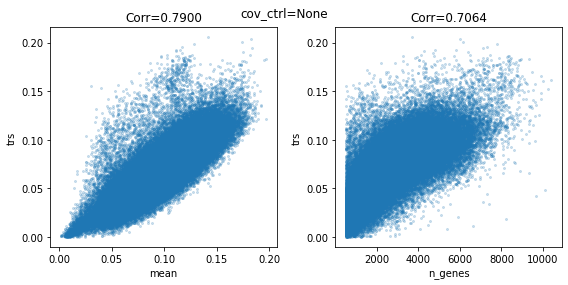

PASS_HDL


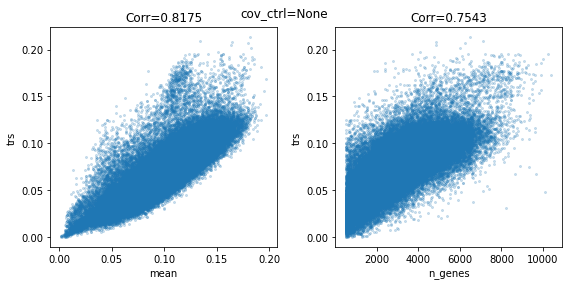

PASS_LDL


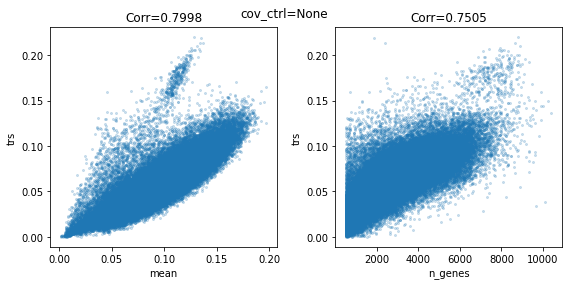

UKB_460K.body_HEIGHTz


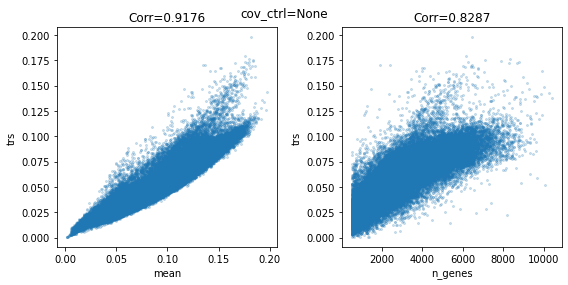

In [10]:
# Raw TRS (without regression)
for trait in trait_list:
    for term in ['']:
        print(trait)
        plt.figure(figsize=[8,4])
        for icov,cov in enumerate(['mean', 'n_genes']):
            plt.subplot(1,2,icov+1)
            plt.scatter(data_facs_ct.obs[cov].values, dic_trs['%s;%strs'%(trait,term)], s=4, alpha=0.2)
            plt.title('Corr=%0.4f'%(np.corrcoef(data_facs_ct.obs[cov].values, dic_trs['%s;%strs'%(trait,term)])[0,1]))
            plt.xlabel(cov)
            plt.ylabel('trs')

        plt.tight_layout()
        term = 'None' if term == '' else term
        term = 'cov_ctrl='+term.replace(';','').replace('_', ' & ')
        plt.suptitle(term)
        plt.show()

# term= 


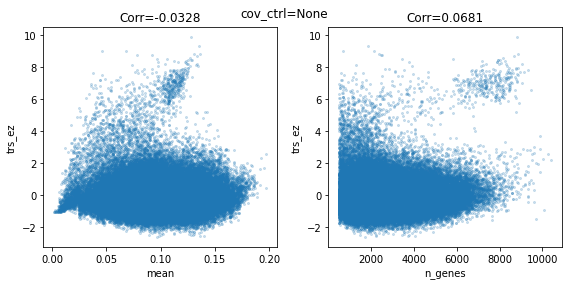

# term= mean;


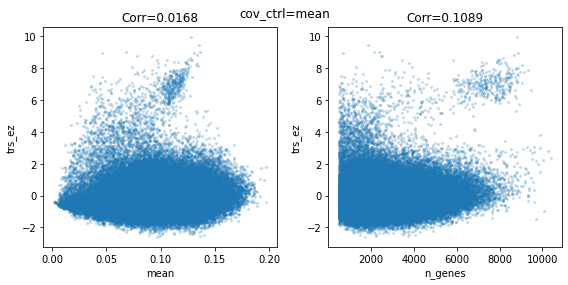

# term= ngene;


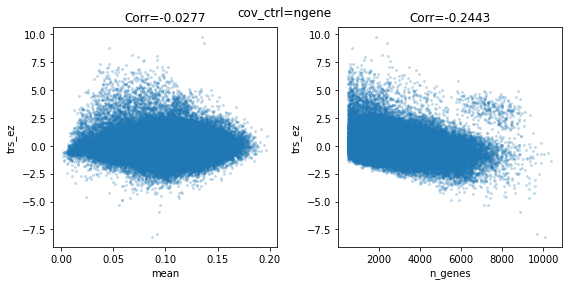

# term= mean_ngene;


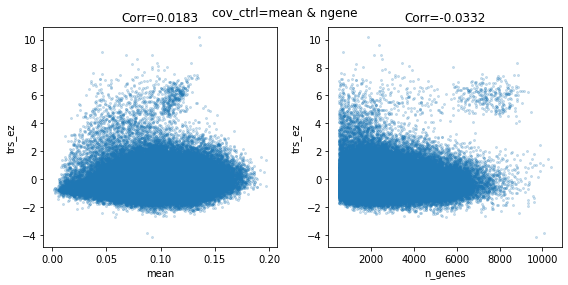

In [14]:
# trs_ez and covariates (all cells)
trait = 'PASS_Alzheimers_Jansen2019'
trait = 'PASS_LDL'
for term in ['', 'mean;', 'ngene;', 'mean_ngene;']:
    print('# term=', term)
    plt.figure(figsize=[8,4])
    for icov,cov in enumerate(['mean', 'n_genes']):
        plt.subplot(1,2,icov+1)
        plt.scatter(data_facs_ct.obs[cov].values, dic_trs['%s;%strs_z'%(trait,term)], s=4, alpha=0.2)
        plt.title('Corr=%0.4f'%(np.corrcoef(data_facs_ct.obs[cov].values, dic_trs['%s;%strs_ez'%(trait,term)])[0,1]))
        plt.xlabel(cov)
        plt.ylabel('trs_ez')
    
    plt.tight_layout()
    term = 'None' if term == '' else term
    term = 'cov_ctrl='+term.replace(';','').replace('_', ' & ')
    plt.suptitle(term)
    plt.show()

# term= 


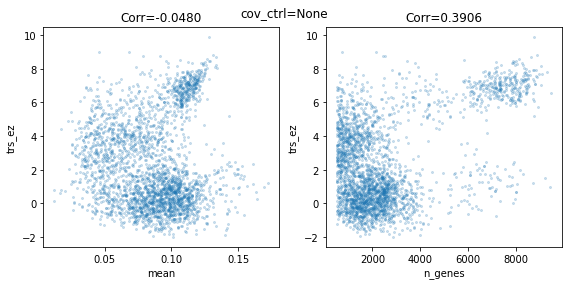

# term= mean;


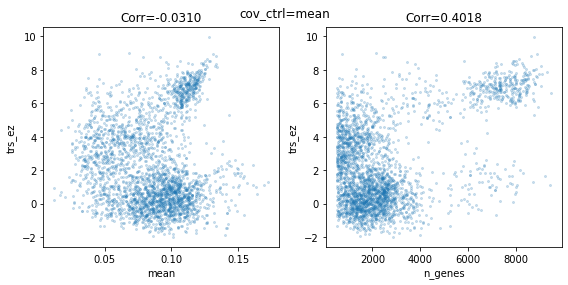

# term= ngene;


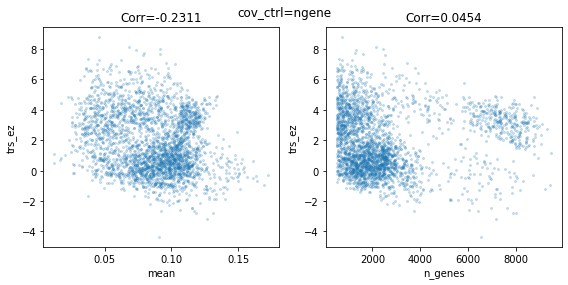

# term= mean_ngene;


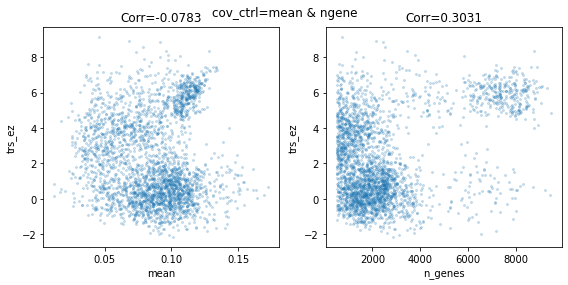

In [13]:
# trs_ez and covariates (liver cells)
trait = 'PASS_Alzheimers_Jansen2019'
trait = 'PASS_LDL'
tissue = 'Liver'
for term in ['', 'mean;', 'ngene;', 'mean_ngene;']:
    print('# term=', term)
    ind_select = data_facs_ct.obs['tissue'] == tissue
    plt.figure(figsize=[8,4])
    for icov,cov in enumerate(['mean', 'n_genes']):
        plt.subplot(1,2,icov+1)
        plt.scatter(data_facs_ct.obs[cov].values[ind_select], 
                    dic_trs['%s;%strs_z'%(trait,term)][ind_select], s=4, alpha=0.2)
        plt.title('Corr=%0.4f'%(np.corrcoef(data_facs_ct.obs[cov].values[ind_select],
                                            dic_trs['%s;%strs_ez'%(trait,term)][ind_select])[0,1]))
        plt.xlabel(cov)
        plt.ylabel('trs_ez')
    
    plt.tight_layout()
    term = 'None' if term == '' else term
    term = 'cov_ctrl='+term.replace(';','').replace('_', ' & ')
    plt.suptitle(term)
    plt.show()

# term= 


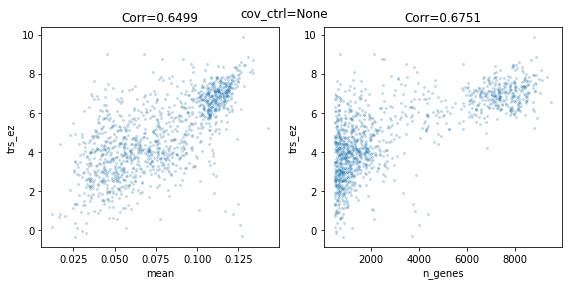

# term= mean;


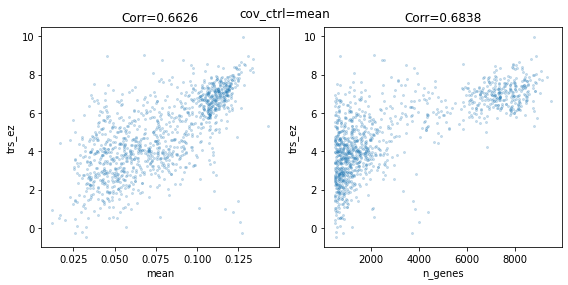

# term= ngene;


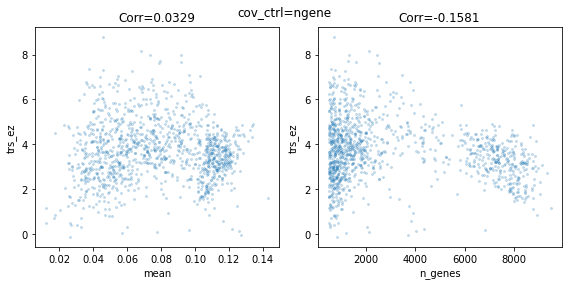

# term= mean_ngene;


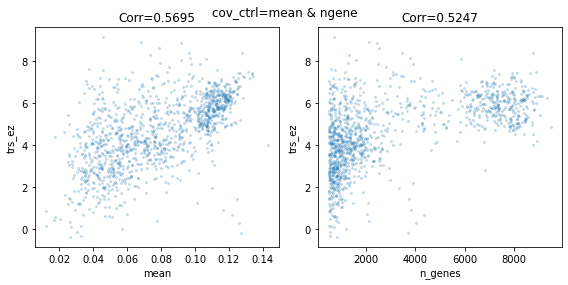

In [17]:
# trs_ez and covariates (liver hepatocytes cells)
trait = 'PASS_Alzheimers_Jansen2019'
trait = 'PASS_LDL'
tissue = 'Liver'
celltype = 'hepatocyte'
for term in ['', 'mean;', 'ngene;', 'mean_ngene;']:
    print('# term=', term)
    ind_select = (data_facs_ct.obs['tissue'] == tissue) & (data_facs_ct.obs['cell_ontology_class'] == celltype)
    plt.figure(figsize=[8,4])
    for icov,cov in enumerate(['mean', 'n_genes']):
        plt.subplot(1,2,icov+1)
        plt.scatter(data_facs_ct.obs[cov].values[ind_select], 
                    dic_trs['%s;%strs_z'%(trait,term)][ind_select], s=4, alpha=0.2)
        plt.title('Corr=%0.4f'%(np.corrcoef(data_facs_ct.obs[cov].values[ind_select],
                                            dic_trs['%s;%strs_ez'%(trait,term)][ind_select])[0,1]))
        plt.xlabel(cov)
        plt.ylabel('trs_ez')
    
    plt.tight_layout()
    term = 'None' if term == '' else term
    term = 'cov_ctrl='+term.replace(';','').replace('_', ' & ')
    plt.suptitle(term)
    plt.show()

In [ ]:
set(data_facs_ct.obs['cell_ontology_class'])

### Old code 

In [ ]:
plot_list = [['Liver', 'PASS_Alzheimers_Jansen2019'],
             ['Liver', 'PASS_HDL'],
             ['Liver', 'PASS_LDL'],
             ['Liver', 'UKB_460K.biochemistry_HDLcholesterol'],
             ['Liver', 'UKB_460K.biochemistry_LDLdirect'],
             ['Liver', 'PASS_BipolarDisorder_Ruderfer2018'],
             ['Liver', 'PASS_Schizophrenia_Pardinas2018'],
             ['Liver', 'PASS_Rheumatoid_Arthritis'],
             ['Liver', 'UKB_460K.body_HEIGHTz']]

tissue_plot = []
for tissue,trait in plot_list:
    
    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ez'] = data=dic_trs['%s;trs_ez'%(trait)]
    temp_df['cov_mean;trs_ez'] = data=dic_trs['%s;mean;trs_ez'%(trait)]
    temp_df['cov_ngene;trs_ez'] = data=dic_trs['%s;ngene;trs_ez'%(trait)]
    temp_df['cov_mean_ngene;trs_ez'] = data=dic_trs['%s;mean_ngene;trs_ez'%(trait)]
    
    df_plot = pd.DataFrame(index=dic_data_facs[tissue].obs.index)
    df_plot['UMAP1'] = dic_data_facs[tissue].obsm['X_umap'][:,0]
    df_plot['UMAP2'] = dic_data_facs[tissue].obsm['X_umap'][:,1]
    df_plot['cell_ontology_class'] = dic_data_facs[tissue].obs['cell_ontology_class']
    
    df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']
    df_plot['cov_mean;trs_ez'] = temp_df.loc[df_plot.index, 'cov_mean;trs_ez']
    df_plot['cov_ngene;trs_ez'] = temp_df.loc[df_plot.index, 'cov_ngene;trs_ez']
    df_plot['cov_mean_ngene;trs_ez'] = temp_df.loc[df_plot.index, 'cov_mean_ngene;trs_ez']
    
    temp_df = df_plot.groupby('cell_ontology_class').agg({'trs_ez':len})
    celltype_list = list(temp_df.index[temp_df['trs_ez']>25])
    celltype_list.sort()
    celltype_set = set(celltype_list)
    df_plot = df_plot.loc[[x in celltype_set for x in df_plot['cell_ontology_class']]]
    
    if len(celltype_list)<=10:
        palette='tab10'
    else:
        palette='tab20'
    
    if tissue not in tissue_plot:
        tissue_plot.append(tissue)
        plt.figure(figsize=[9,6])
        sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                        hue='cell_ontology_class', hue_order=celltype_list, palette=palette,
                        s=16, linewidth=0.1)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.tight_layout()
        plt.title(tissue)
        plt.show()
    
    for term in ['trs_ez', 'cov_mean;trs_ez', 'cov_ngene;trs_ez', 'cov_mean_ngene;trs_ez']:
        plt.figure(figsize=[7,6])
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[term],
                    cmap='RdBu_r', vmin=-5, vmax=5, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s\nTRS z-score %s'%(trait, term.replace('trs_ez','').replace(';','')))
        plt.tight_layout()
        plt.show()
#     break

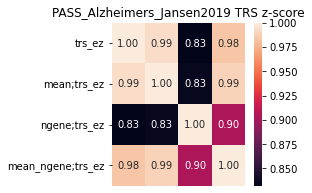

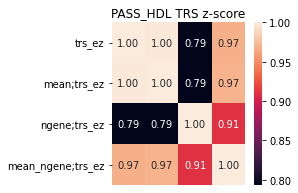

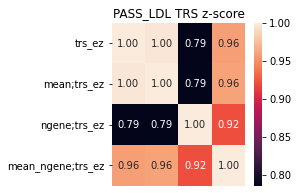

In [31]:
### Correlation between different covariate control methods 
for trait in ['PASS_Alzheimers_Jansen2019', 'PASS_HDL', 'PASS_LDL']:
    df_plot = pd.DataFrame()
    for term in ['trs_ez', 'mean;trs_ez', 'ngene;trs_ez', 'mean_ngene;trs_ez']:
        df_plot[term] = dic_trs['%s;%s'%(trait,term)]

    df_plot = df_plot.corr()
    plt.figure(figsize=[3,3])
    sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
    plt.title('%s TRS z-score'%trait)
    plt.show()

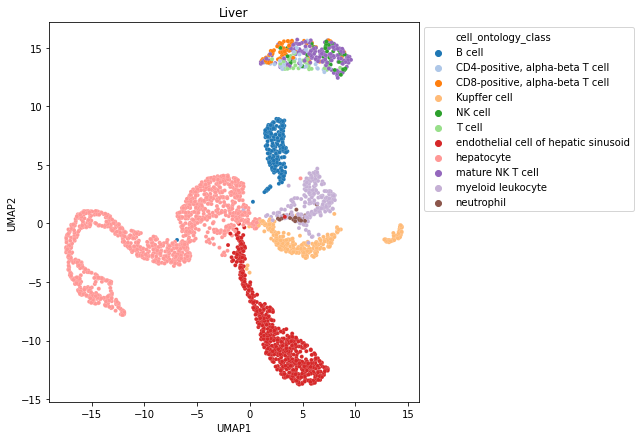

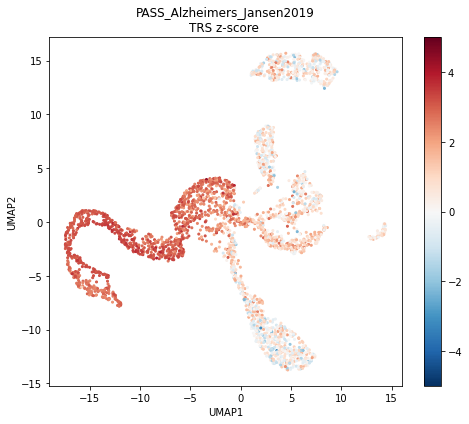

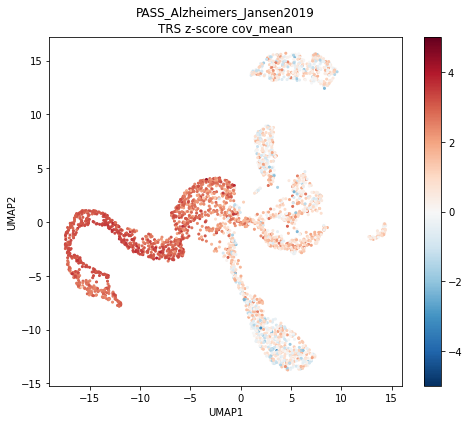

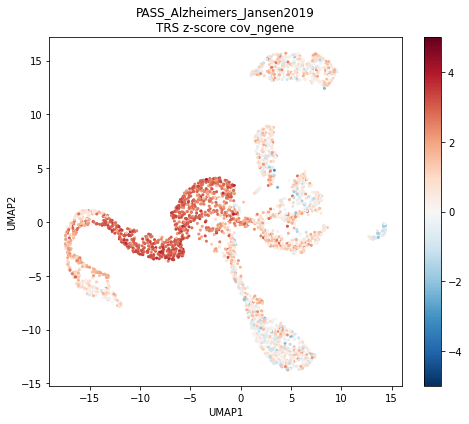

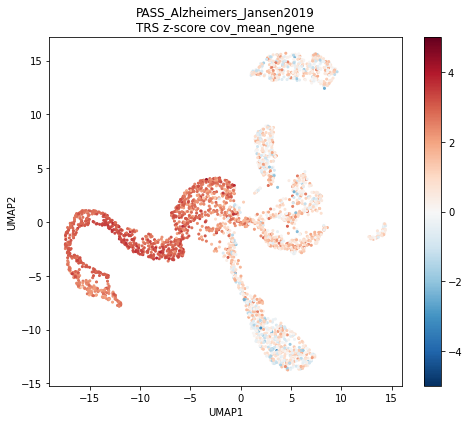

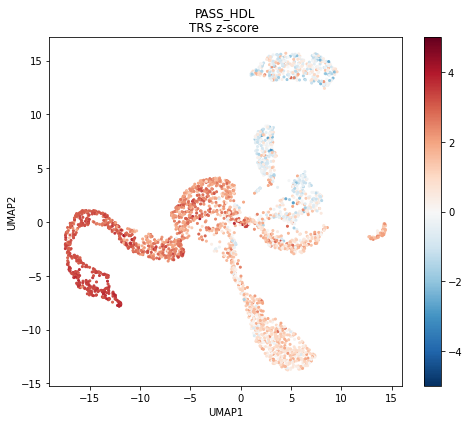

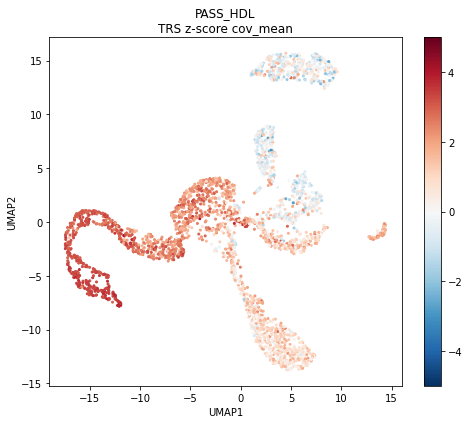

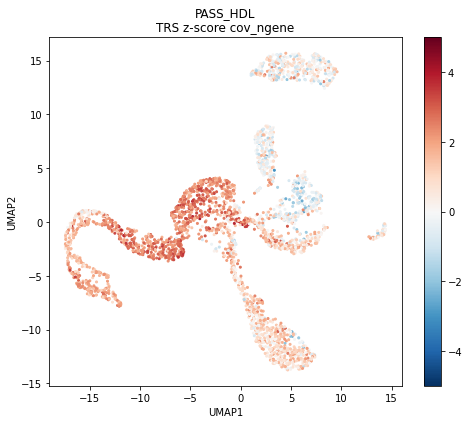

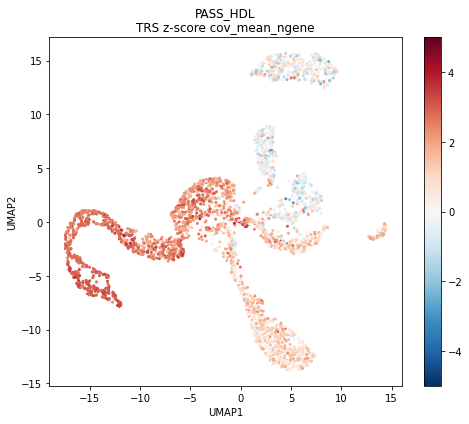

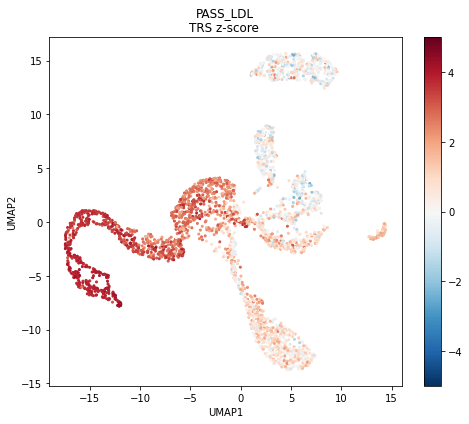

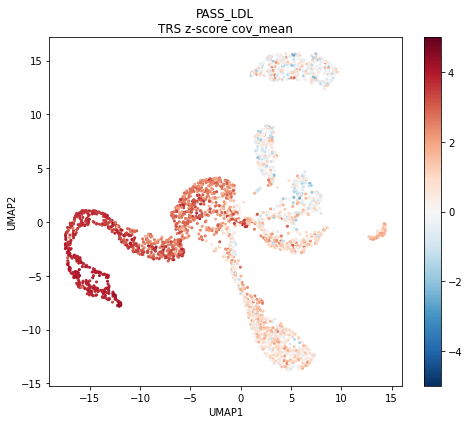

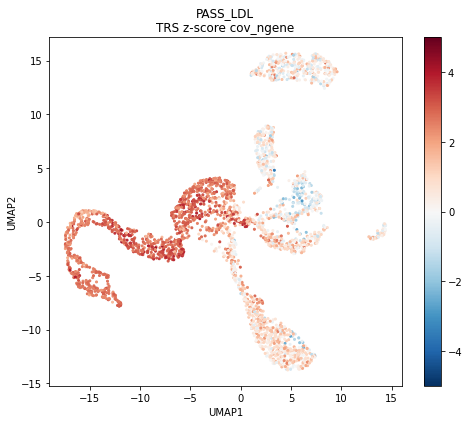

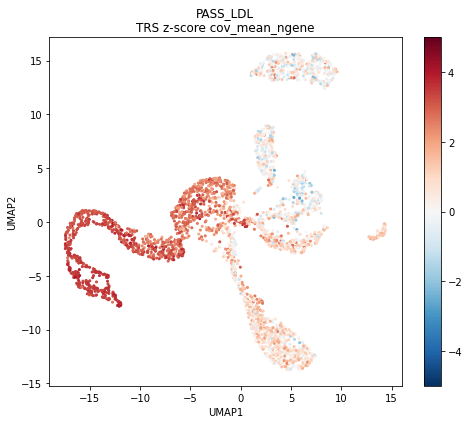

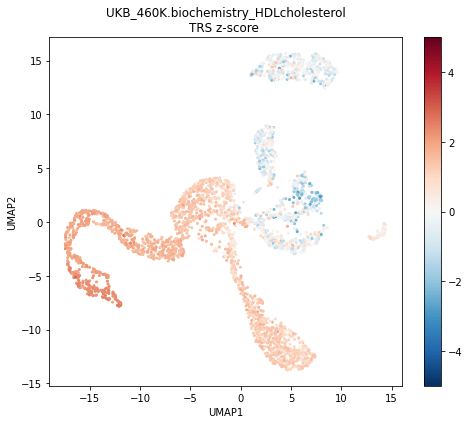

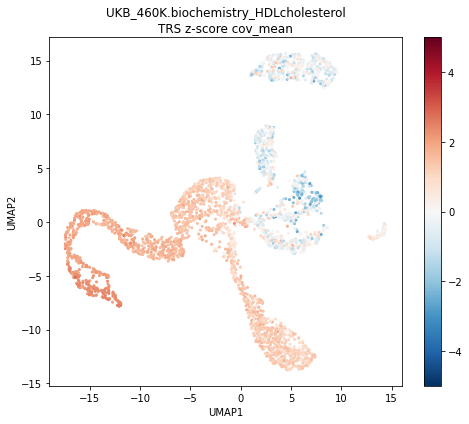

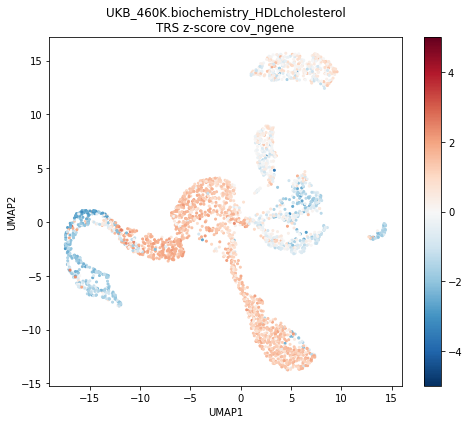

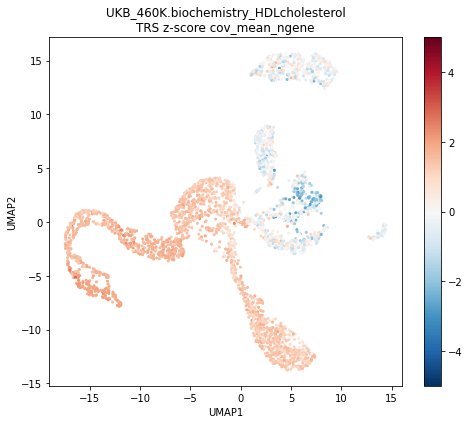

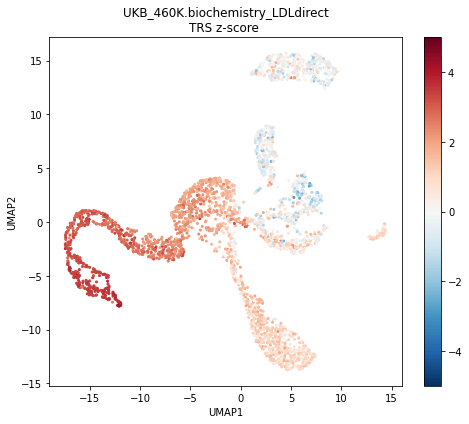

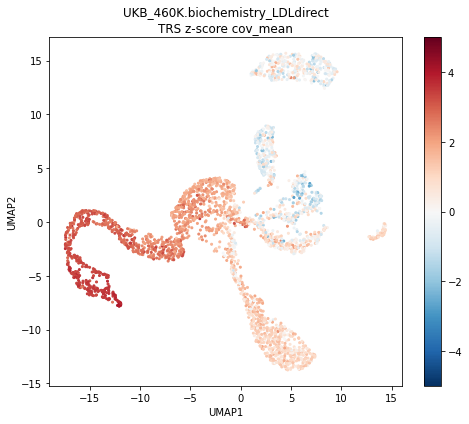

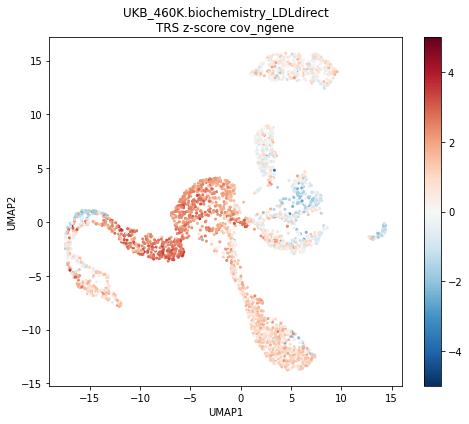

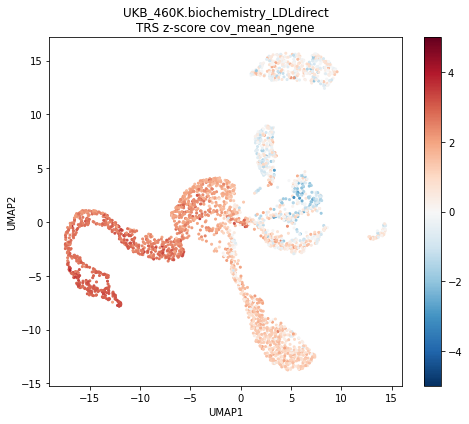

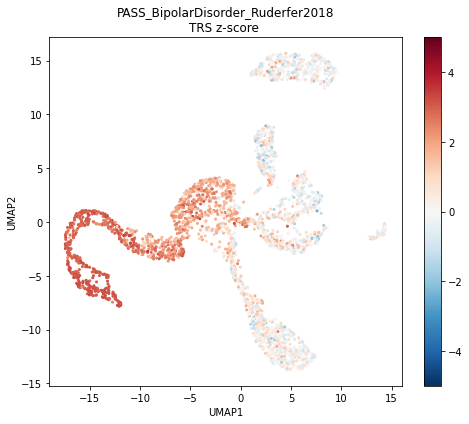

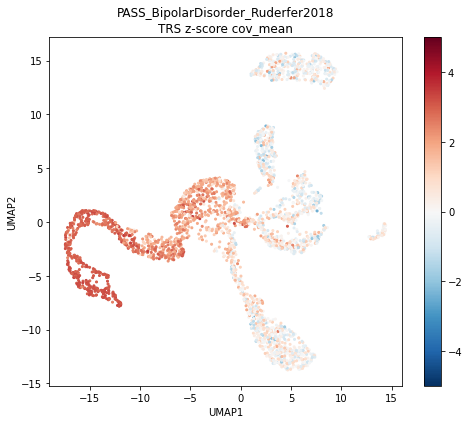

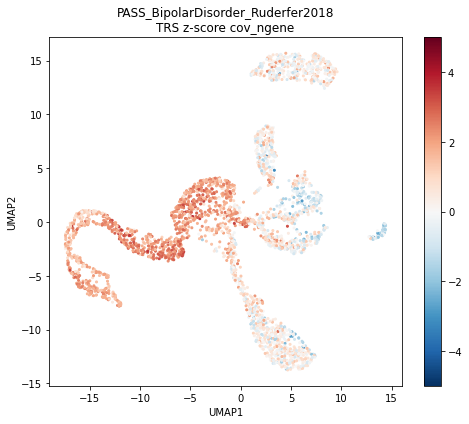

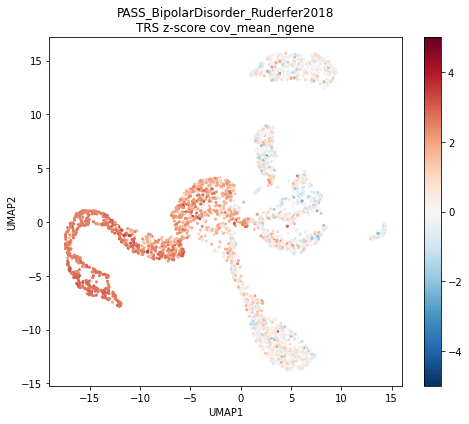

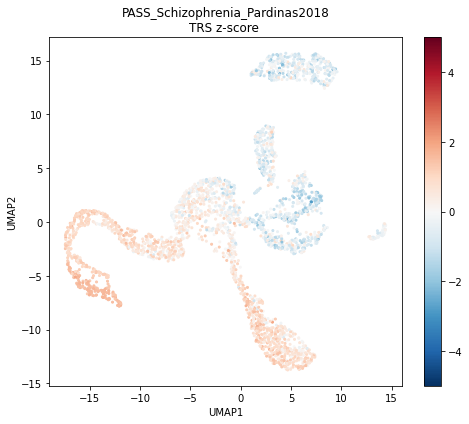

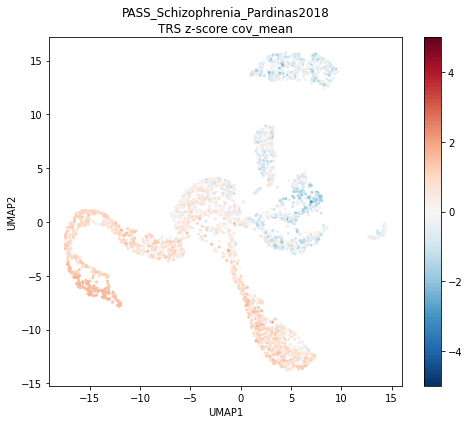

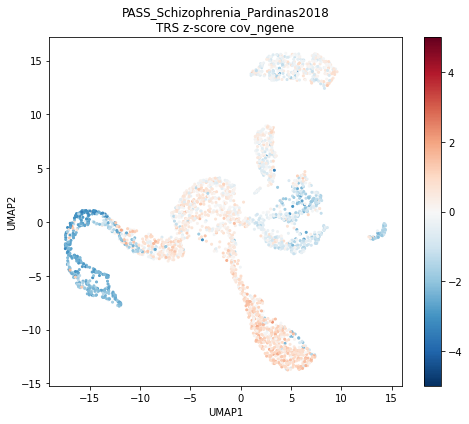

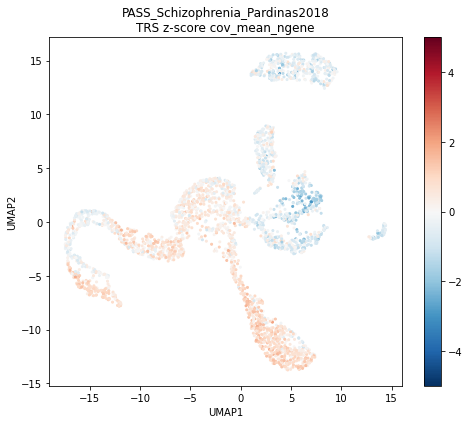

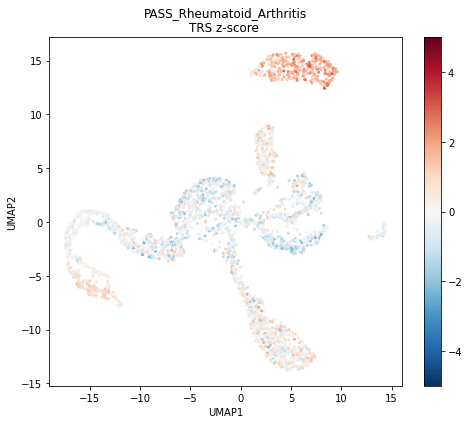

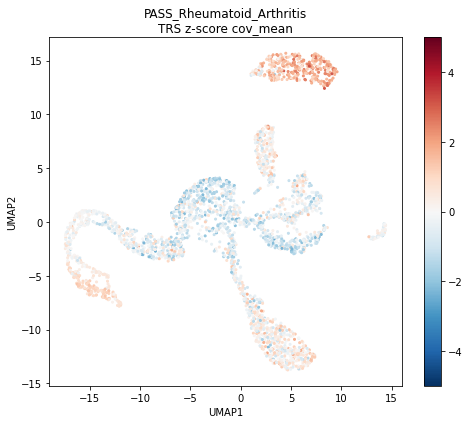

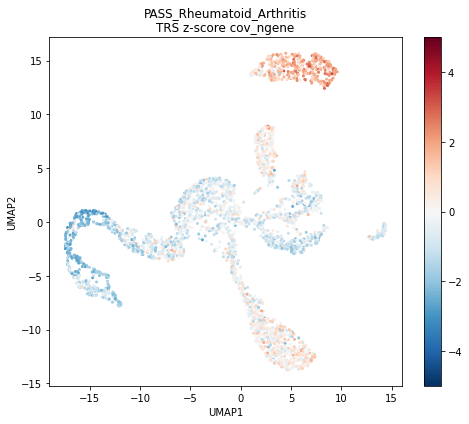

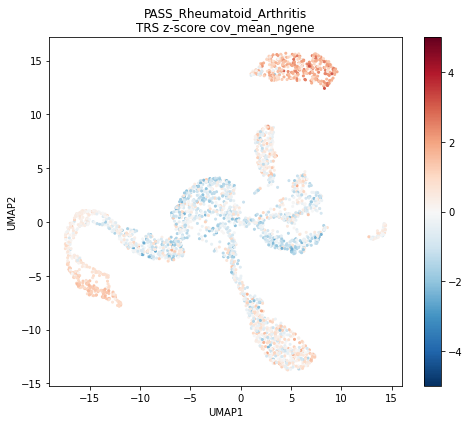

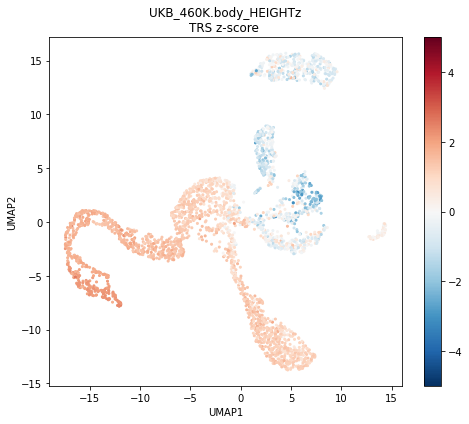

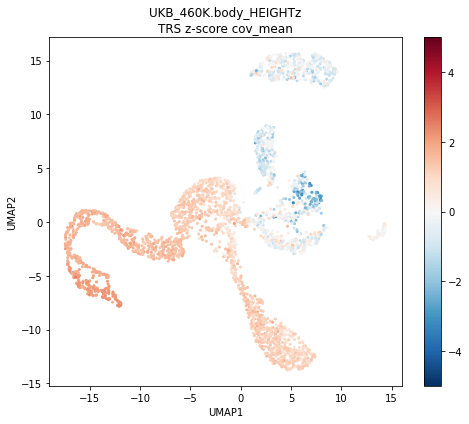

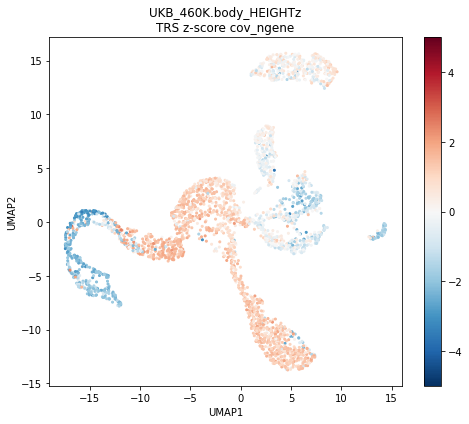

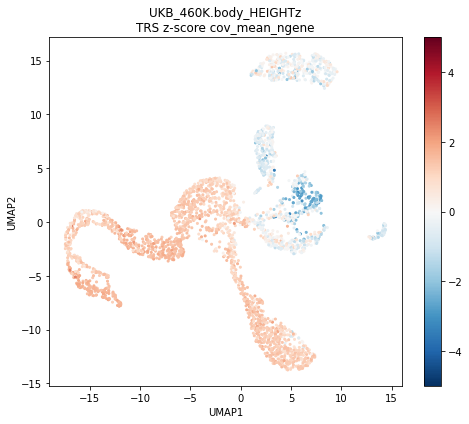

### Compare TRS and TRS gene sets 

In [32]:
# from matplotlib_venn import venn2
# from matplotlib_venn import venn3

# dic_trs_geneset = {}
# for trait in trait_list:
#     ind_select = (dic_geneset[trait]['fdr'].values<0.1)
#     dic_trs_geneset[trait] = set(dic_geneset[trait].index[ind_select])

# plot_list = ['PASS_Alzheimers_Jansen2019', 'PASS_HDL', 'PASS_LDL']
# plt.figure(figsize=[5,5])
# venn3([dic_trs_geneset[x] for x in plot_list], plot_list)
# plt.show()

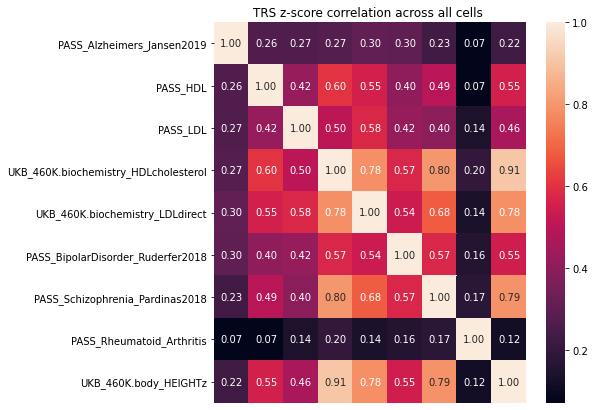

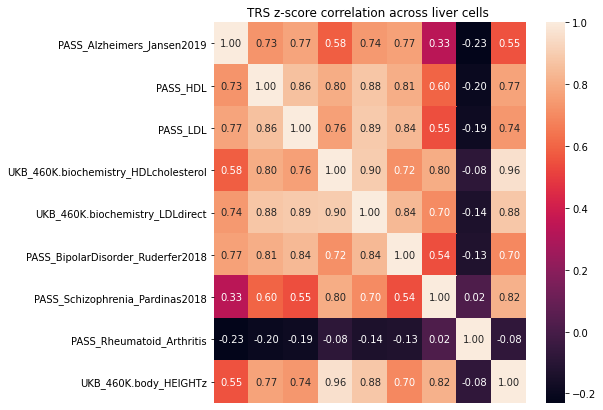

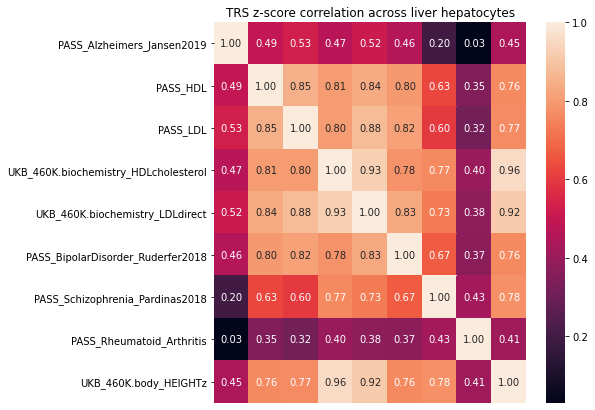

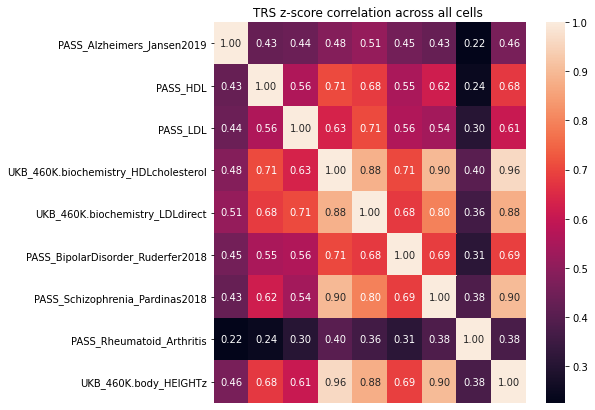

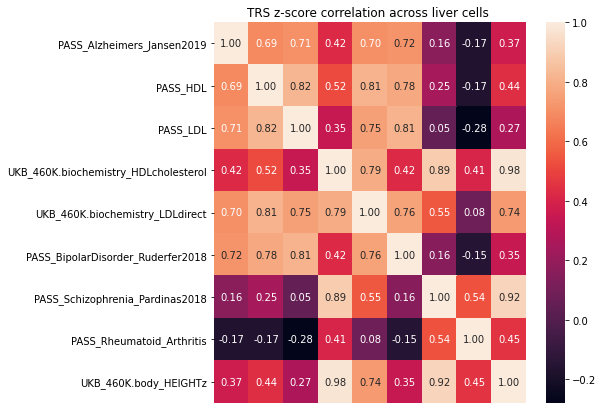

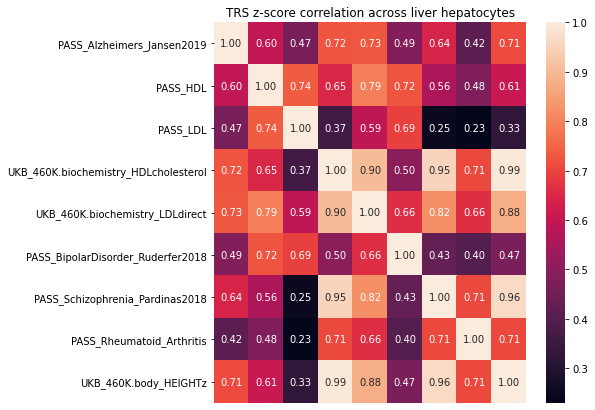

In [33]:
trait_analysis_list = trait_list

for term in ['trs_ez', 'ngene;trs_ez']:
    # 
    df_plot = pd.DataFrame()
    for trait in trait_analysis_list:
        df_plot[trait] = dic_trs['%s;%s'%(trait, term)]

    df_plot = df_plot.corr()
    plt.figure(figsize=[7,7])
    sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
    plt.title('TRS z-score correlation across all cells ')
    plt.show()

    # 
    ind_select = (data_facs_ct.obs['tissue']=='Liver')
    df_plot = pd.DataFrame()
    for trait in trait_analysis_list:
        df_plot[trait] = dic_trs['%s;%s'%(trait, term)][ind_select]

    df_plot = df_plot.corr()
    plt.figure(figsize=[7,7])
    sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
    plt.title('TRS z-score correlation across liver cells ')
    plt.show()

    # 
    ind_select = (data_facs_ct.obs['tissue']=='Liver')&(data_facs_ct.obs['cell_ontology_class']=='hepatocyte')
    df_plot = pd.DataFrame()
    for trait in trait_analysis_list:
        df_plot[trait] = dic_trs['%s;%s'%(trait, term)][ind_select]

    df_plot = df_plot.corr()
    plt.figure(figsize=[7,7])
    sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
    plt.title('TRS z-score correlation across liver hepatocytes')
    plt.show()

### TRS-correlated genes

In [49]:
df_gene_corr = pd.DataFrame(index=data_facs_ct.var_names)
for trait in trait_list:
    for term in ['trs_ez', 'ngene;trs_ez', 'mean;trs_ez', 'mean_ngene;trs_ez']:
        print(trait, term)
    
        ind_select = (data_facs_ct.obs['tissue']=='Liver')&(data_facs_ct.obs['cell_ontology_class']=='hepatocyte')
        anndata_celltype = data_facs_ct[ind_select,:].copy()
        anndata_celltype.obs['trs_ez'] = dic_trs['%s;%s'%(trait,term)][ind_select]
        md.rank_trs_genes(anndata_celltype, method='pearson_corr')
        df_gene_corr['%s;%s'%(trait,term)] = anndata_celltype.var[['trs_corr']].copy()
# RESULT_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/result'
# df_gene_corr.to_csv(RESULT_PATH+'/gene_trs_corr_hepatocyte_100220', sep='\t')

PASS_Alzheimers_Jansen2019 trs_ez
PASS_Alzheimers_Jansen2019 ngene;trs_ez
PASS_Alzheimers_Jansen2019 mean;trs_ez
PASS_Alzheimers_Jansen2019 mean_ngene;trs_ez
PASS_HDL trs_ez
PASS_HDL ngene;trs_ez
PASS_HDL mean;trs_ez
PASS_HDL mean_ngene;trs_ez
PASS_LDL trs_ez
PASS_LDL ngene;trs_ez
PASS_LDL mean;trs_ez
PASS_LDL mean_ngene;trs_ez
UKB_460K.biochemistry_HDLcholesterol trs_ez
UKB_460K.biochemistry_HDLcholesterol ngene;trs_ez
UKB_460K.biochemistry_HDLcholesterol mean;trs_ez
UKB_460K.biochemistry_HDLcholesterol mean_ngene;trs_ez
UKB_460K.biochemistry_LDLdirect trs_ez
UKB_460K.biochemistry_LDLdirect ngene;trs_ez
UKB_460K.biochemistry_LDLdirect mean;trs_ez
UKB_460K.biochemistry_LDLdirect mean_ngene;trs_ez
PASS_BipolarDisorder_Ruderfer2018 trs_ez
PASS_BipolarDisorder_Ruderfer2018 ngene;trs_ez
PASS_BipolarDisorder_Ruderfer2018 mean;trs_ez
PASS_BipolarDisorder_Ruderfer2018 mean_ngene;trs_ez
PASS_Schizophrenia_Pardinas2018 trs_ez
PASS_Schizophrenia_Pardinas2018 ngene;trs_ez
PASS_Schizophrenia_Pardi

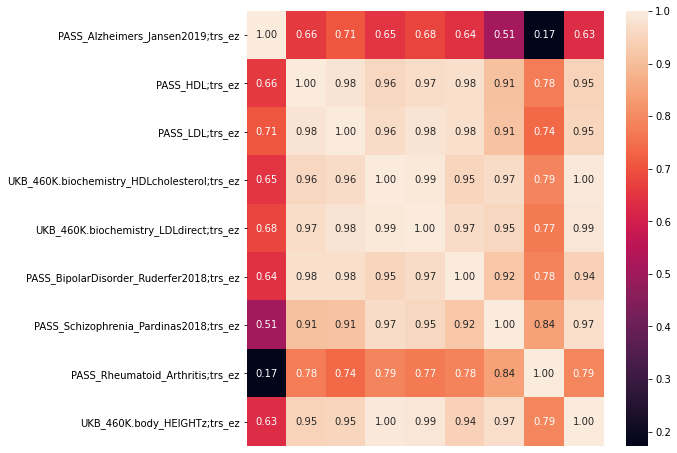

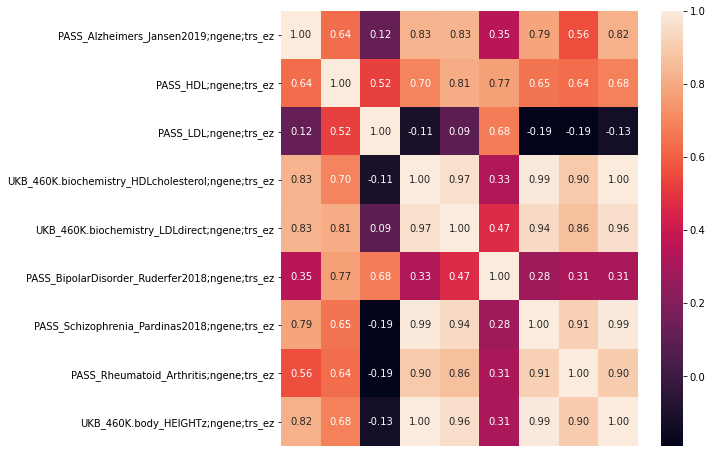

In [41]:
for term in ['trs_ez', 'ngene;trs_ez']:
    df_plot = df_gene_corr[[x for x in df_gene_corr.columns if x.replace(x.split(';')[0],'')[1:]==term]].corr()
    plt.figure(figsize=[8,8])
    sns.heatmap(df_plot, annot=df_plot, fmt='0.2f', xticklabels=False)
    plt.show()

### ALZ KEGG genes has more overlap with TRS-correlated genes 

In [42]:
fname = '/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/gene_annotation/'\
        'msigdb_v7.1_files_to_download_locally/msigdb_v7.1_GMTs/c2.cp.kegg.v7.1.symbols.gmt'
with open(fname, 'r') as f:
    for i_line,line in enumerate(f):
        if 'ALZH' in line:
            print(i_line, line.split('\t'))
            break
alz_gene_list = [dic_mapping[x.strip()] for x in line.split('\t')[2:] 
                 if x.strip() in dic_mapping.keys()]

152 ['KEGG_ALZHEIMERS_DISEASE', 'http://www.gsea-msigdb.org/gsea/msigdb/cards/KEGG_ALZHEIMERS_DISEASE', 'UQCR10', 'NAE1', 'CALM2', 'NDUFA5', 'NDUFA4', 'COX6CP3', 'CALM1', 'ATP2A1', 'PPP3R2', 'EIF2AK3', 'PPP3CC', 'ATP2A3', 'PPP3R1', 'ATP2A2', 'NDUFS7', 'MT-CYB', 'ADAM17', 'BACE2', 'ATP5PO', 'MT-CO2', 'MT-CO1', 'COX8C', 'MME', 'MT-CO3', 'COX5B', 'ITPR3', 'PSENEN', 'LRP1', 'COX4I1', 'APOE', 'MT-ATP6', 'MT-ATP8', 'CHP2', 'ATP5PD', 'NDUFA2', 'NDUFA3', 'NDUFA1', 'CAPN2', 'LPL', 'CAPN1', 'APAF1', 'ATP5MC1P5', 'HSD17B10', 'APH1A', 'UQCRQ', 'ATP5F1D', 'CALML5', 'GAPDH', 'ATF6', 'COX7A2L', 'IDE', 'ATP5MC3', 'ATP5MC2', 'ADAM10', 'ATP5MC1', 'ATP5PB', 'ATP5F1E', 'COX5A', 'CDK5R1', 'ERN1', 'GNAQ', 'UQCRHL', 'ATP5F1A', 'BACE1', 'CALML3', 'APBB1', 'ATP5PF', 'CYCS', 'SDHA', 'CALM3', 'NDUFA4L2', 'NCSTN', 'CASP9', 'PLCB2', 'COX8A', 'CASP8', 'COX7C', 'CASP7', 'PLCB1', 'PLCB3', 'PLCB4', 'TNF', 'RYR3', 'FADD', 'SDHD', 'SDHB', 'SDHC', 'COX7B', 'BAD', 'COX7A1', 'COX7A2', 'COX6C', 'ATP5F1B', 'GRIN1', 'GRIN2A',

In [78]:
trait='PASS_Alzheimers_Jansen2019'

ind_select = (dic_geneset[trait]['fdr'].values<0.2)
trait_gene_list = dic_geneset[trait].index[ind_select]
print('# KEGG_ALZ_gene=%d, MAGMA_ALZ_gene=%d, OVERLAP=%d'
      %(len(alz_gene_list), len(trait_gene_list), len(set(trait_gene_list) & set(alz_gene_list))))
        
for term in ['trs_ez', 'ngene;trs_ez', 'mean;trs_ez', 'mean_ngene;trs_ez']:
    temp_df = df_gene_corr[['%s;%s'%(trait, term)]].copy()
    temp_df.sort_values(by='%s;%s'%(trait, term), inplace=True)
    gene_list = list(temp_df.index[-len(trait_gene_list):])
    print('# KEGG_ALZ_gene=%d, TRS_corr_gene;%s=%d, OVERLAP=%d'
          %(len(alz_gene_list), term.replace('trs_ez',''), len(gene_list), 
            len(set(gene_list) & set(alz_gene_list))))

# KEGG_ALZ_gene=137, MAGMA_ALZ_gene=469, OVERLAP=7
# KEGG_ALZ_gene=137, TRS_corr_gene;=469, OVERLAP=39
# KEGG_ALZ_gene=137, TRS_corr_gene;ngene;=469, OVERLAP=38
# KEGG_ALZ_gene=137, TRS_corr_gene;mean;=469, OVERLAP=38
# KEGG_ALZ_gene=137, TRS_corr_gene;mean_ngene;=469, OVERLAP=42


### Compare MAGMA genes and TRS-corr genes on a reference GWAS data

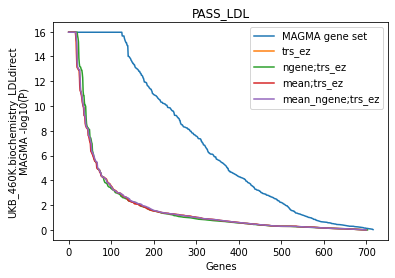

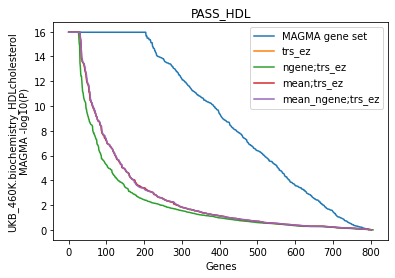

In [69]:
plot_list = [['PASS_LDL', 'UKB_460K.biochemistry_LDLdirect'],
             ['PASS_HDL', 'UKB_460K.biochemistry_HDLcholesterol']]

for tar_trait,ref_trait in plot_list:
    
    df_ref_trait = dic_geneset[ref_trait].copy()
    df_ref_trait.loc[df_ref_trait['p_val']==0,'p_val'] = \
        df_ref_trait.loc[df_ref_trait['p_val']>0,'p_val'].min()
    df_ref_trait['nlog10p'] = -np.log10(df_ref_trait['p_val'].values)
    
    # MAGMA geneset 
    ind_select = (dic_geneset[tar_trait]['fdr'].values<0.2)
    magma_gene_list = list(set(dic_geneset[tar_trait].index[ind_select]))
    
    plt.figure()
    v_nlogp = df_ref_trait.loc[magma_gene_list,'nlog10p'].values
    v_nlogp = np.sort(v_nlogp)[::-1]
    plt.plot(np.arange(v_nlogp.shape[0]), v_nlogp, c='C0', label='MAGMA gene set')

    
    for iterm,term in enumerate(['trs_ez', 'ngene;trs_ez', 'mean;trs_ez', 'mean_ngene;trs_ez']):
        
        # TRS-correlated geneset
        overlap_gene_list = list(set(df_gene_corr.index)&set(dic_geneset[tar_trait].index))
        temp_df = df_gene_corr.loc[overlap_gene_list, ['%s;%s'%(tar_trait,term)]].copy()
        temp_df.sort_values(by='%s;%s'%(tar_trait,term), inplace=True)
        trscorr_gene_list =  list(temp_df.index[-len(magma_gene_list):])
        
        v_nlogp = df_ref_trait.loc[trscorr_gene_list,'nlog10p'].values
        v_nlogp = np.sort(v_nlogp)[::-1]
        plt.plot(np.arange(v_nlogp.shape[0]), v_nlogp, c='C%d'%(iterm+1), label=term)

    plt.ylabel('%s\nMAGMA -log10(P)'%ref_trait)
    plt.xlabel('Genes')
    plt.legend()
    plt.title(tar_trait)
    plt.show()

### Pathway analysis

In [71]:
from gprofiler import GProfiler
dic_pathway = {}
for trait in trait_list:
    for iterm,term in enumerate(['trs_ez', 'ngene;trs_ez']):

        temp_df = df_gene_corr[['%s;%s'%(trait,term)]].copy()
        temp_df.sort_values(by='%s;%s'%(trait,term), inplace=True)
        gene_list = list(temp_df.index[-100:])

        gp = GProfiler(return_dataframe=True)
        df_pathway = gp.profile(organism='mmusculus', query=gene_list,
                                sources=['GO:BP', 'KEGG'], significance_threshold_method='fdr', 
                                user_threshold=0.01, background=list(data_facs_ct.var_names))
        dic_pathway['%s;%s'%(trait,term)] = df_pathway.copy()
        print(trait, term)

PASS_Alzheimers_Jansen2019 trs_ez
PASS_Alzheimers_Jansen2019 ngene;trs_ez
PASS_HDL trs_ez
PASS_HDL ngene;trs_ez
PASS_LDL trs_ez
PASS_LDL ngene;trs_ez
UKB_460K.biochemistry_HDLcholesterol trs_ez
UKB_460K.biochemistry_HDLcholesterol ngene;trs_ez
UKB_460K.biochemistry_LDLdirect trs_ez
UKB_460K.biochemistry_LDLdirect ngene;trs_ez
PASS_BipolarDisorder_Ruderfer2018 trs_ez
PASS_BipolarDisorder_Ruderfer2018 ngene;trs_ez
PASS_Schizophrenia_Pardinas2018 trs_ez
PASS_Schizophrenia_Pardinas2018 ngene;trs_ez
PASS_Rheumatoid_Arthritis trs_ez
PASS_Rheumatoid_Arthritis ngene;trs_ez
UKB_460K.body_HEIGHTz trs_ez
UKB_460K.body_HEIGHTz ngene;trs_ez


In [74]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('./pathway_top100.101320.xlsx', engine='xlsxwriter')
for term in dic_pathway.keys():
    temp_df = dic_pathway[term].copy()
    ind_select = (temp_df['term_size']<1000)&(temp_df['precision']>0.2)
    temp_df.loc[ind_select].to_excel(writer, sheet_name=term.split(';')[0][0:15]+';'+term.split(';')[1])
writer.save()

### Liver hepatocyte marker genes 

In [79]:
# Liver hepatocyte markers 

tms_gene_set = set(data_facs_ct.var_names)

# PanglaoDB_Franzen_Database_2019
df_pl = pd.read_csv(DATA_PATH+'/celltype_marker/PanglaoDB_Franzen_Database_2019/PanglaoDB_markers_27_Mar_2020.tsv',
                    sep='\t')
ind_select = (df_pl['cell type']=='Hepatocytes') & (df_pl['species'].isin(['Mm', 'Mm Hs'])) &\
                 (df_pl['canonical marker']==1) & (df_pl['specificity_mouse']>0.01) & (df_pl['sensitivity_mouse']>0.01)
hep_marker_pl = list(df_pl.loc[ind_select]['official gene symbol'].values)
hep_marker_pl = [dic_mapping[x] for x in hep_marker_pl if (x in dic_mapping.keys())]
hep_marker_pl = [x for x in hep_marker_pl if x in tms_gene_set]

# CellMarker_Zhang_NAR_2019
df_cm = pd.read_csv(DATA_PATH+'/celltype_marker/CellMarker_Zhang_NAR_2019/Mouse_cell_markers.txt', sep='\t')
ind_select = (df_cm['cellName']=='Hepatocyte') 
hep_marker_cm = []
for list_ in df_cm.loc[ind_select, 'geneSymbol']:
    hep_marker_cm += list_.split(',')
hep_marker_cm = [x.strip() for x in hep_marker_cm]
hep_marker_cm = [x for x in hep_marker_cm if x in tms_gene_set]

hep_marker = list(set(hep_marker_pl + hep_marker_cm))
hep_marker.sort()

print('# PanglaoDB hepatocyte markers: %d'%(len(hep_marker_pl)))
print('# CellMarker hepatocyte markers: %d'%(len(hep_marker_cm)))
print('# Union: %d'%(len(hep_marker)))


# PanglaoDB hepatocyte markers: 28
# CellMarker hepatocyte markers: 14
# Union: 36


In [80]:
# Obtain TRS
dic_trs = {}

start_time = time.time()
trait='hep_marker'    
gene_list = hep_marker
    
# No covariates
md.score_cell(data_facs_ct, gene_list, suffix='',
              ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
              n_ctrl=10, n_genebin=200, cov_list=None,
              return_list=['trs', 'trs_z', 'trs_ep', 'trs_ez'], verbose=False)

dic_trs['%s;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
dic_trs['%s;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
dic_trs['%s;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
dic_trs['%s;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()

# mean
md.score_cell(data_facs_ct, gene_list, suffix='',
              ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
              n_ctrl=10, n_genebin=200, cov_list=['mean'],
              return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], verbose=False)

dic_trs['%s;mean;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
dic_trs['%s;mean;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
dic_trs['%s;mean;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
dic_trs['%s;mean;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()

# n_genes
md.score_cell(data_facs_ct, gene_list, suffix='',
              ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
              n_ctrl=10, n_genebin=200, cov_list=['n_genes'],
              return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], verbose=False)

dic_trs['%s;ngene;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
dic_trs['%s;ngene;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
dic_trs['%s;ngene;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
dic_trs['%s;ngene;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()

# mean, n_genes
md.score_cell(data_facs_ct, gene_list, suffix='',
              ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
              n_ctrl=10, n_genebin=200, cov_list=['mean', 'n_genes'],
              return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], verbose=False)

dic_trs['%s;mean_ngene;trs'%(trait)] = data_facs_ct.obs['trs'].values.copy()
dic_trs['%s;mean_ngene;trs_z'%(trait)] = data_facs_ct.obs['trs_z'].values.copy()
dic_trs['%s;mean_ngene;trs_ep'%(trait)] = data_facs_ct.obs['trs_ep'].values.copy()
dic_trs['%s;mean_ngene;trs_ez'%(trait)] = data_facs_ct.obs['trs_ez'].values.copy()

print('#%-40s time=%0.1fs'%(trait,time.time()-start_time))

#hep_marker                               time=30.0s


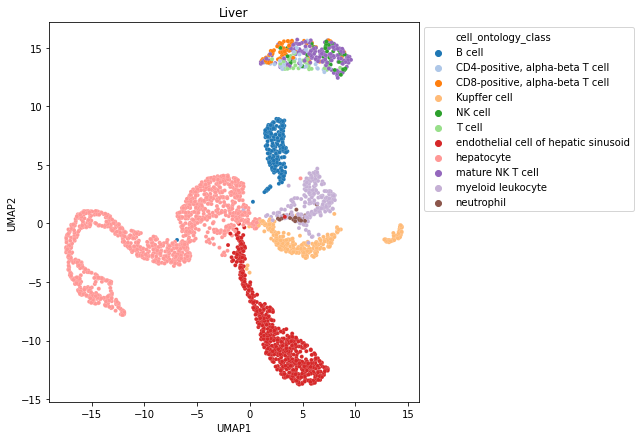

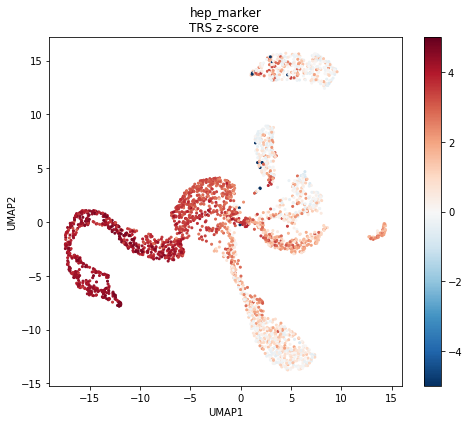

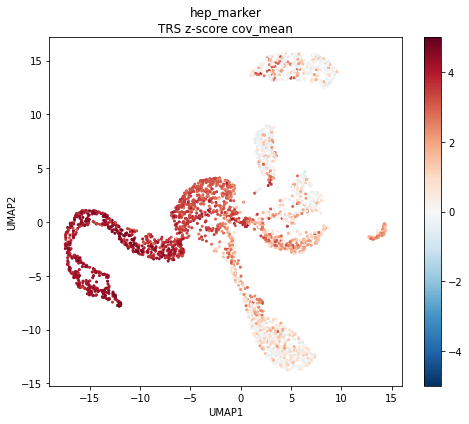

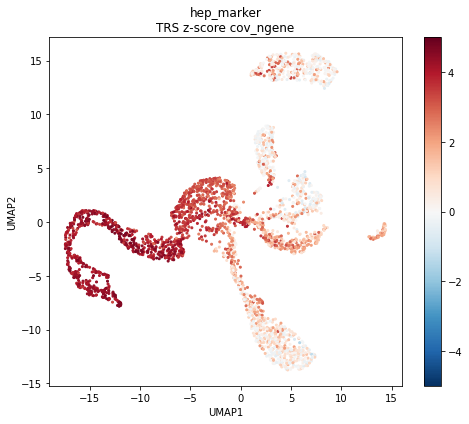

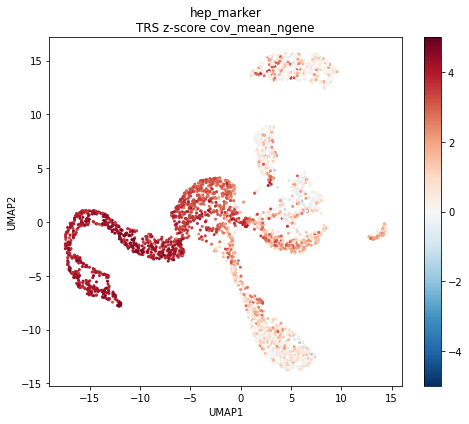

In [81]:
plot_list = [['Liver', 'hep_marker']]

tissue_plot = []
for tissue,trait in plot_list:
    
    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ez'] = data=dic_trs['%s;trs_ez'%(trait)]
    temp_df['cov_mean;trs_ez'] = data=dic_trs['%s;mean;trs_ez'%(trait)]
    temp_df['cov_ngene;trs_ez'] = data=dic_trs['%s;ngene;trs_ez'%(trait)]
    temp_df['cov_mean_ngene;trs_ez'] = data=dic_trs['%s;mean_ngene;trs_ez'%(trait)]
    
    df_plot = pd.DataFrame(index=dic_data_facs[tissue].obs.index)
    df_plot['UMAP1'] = dic_data_facs[tissue].obsm['X_umap'][:,0]
    df_plot['UMAP2'] = dic_data_facs[tissue].obsm['X_umap'][:,1]
    df_plot['cell_ontology_class'] = dic_data_facs[tissue].obs['cell_ontology_class']
    
    df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']
    df_plot['cov_mean;trs_ez'] = temp_df.loc[df_plot.index, 'cov_mean;trs_ez']
    df_plot['cov_ngene;trs_ez'] = temp_df.loc[df_plot.index, 'cov_ngene;trs_ez']
    df_plot['cov_mean_ngene;trs_ez'] = temp_df.loc[df_plot.index, 'cov_mean_ngene;trs_ez']
    
    temp_df = df_plot.groupby('cell_ontology_class').agg({'trs_ez':len})
    celltype_list = list(temp_df.index[temp_df['trs_ez']>25])
    celltype_list.sort()
    celltype_set = set(celltype_list)
    df_plot = df_plot.loc[[x in celltype_set for x in df_plot['cell_ontology_class']]]
    
    if len(celltype_list)<=10:
        palette='tab10'
    else:
        palette='tab20'
    
    if tissue not in tissue_plot:
        tissue_plot.append(tissue)
        plt.figure(figsize=[9,6])
        sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                        hue='cell_ontology_class', hue_order=celltype_list, palette=palette,
                        s=16, linewidth=0.1)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.tight_layout()
        plt.title(tissue)
        plt.show()
    
    for term in ['trs_ez', 'cov_mean;trs_ez', 'cov_ngene;trs_ez', 'cov_mean_ngene;trs_ez']:
        plt.figure(figsize=[7,6])
        plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot[term],
                    cmap='RdBu_r', vmin=-5, vmax=5, s=4)
        plt.colorbar()
        plt.xlabel('UMAP1')
        plt.ylabel('UMAP2')
        plt.title('%s\nTRS z-score %s'%(trait, term.replace('trs_ez','').replace(';','')))
        plt.tight_layout()
        plt.show()
#     break

### Old code

/n/home11/mjzhang/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  app.launch_new_instance()


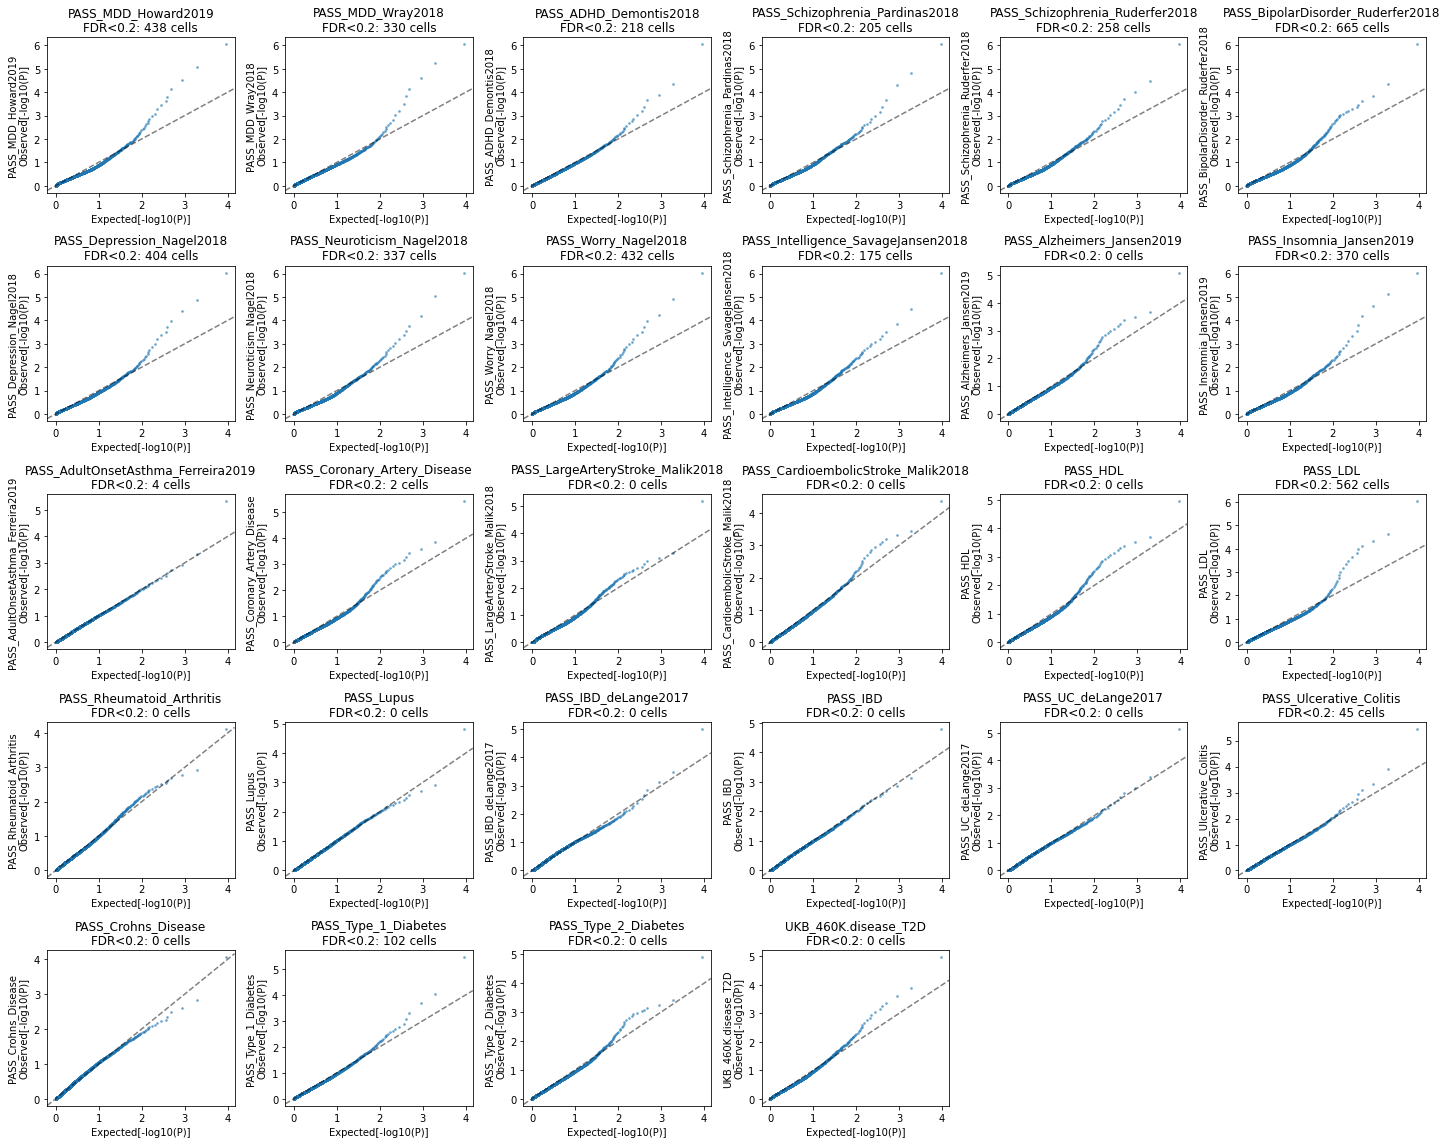

In [60]:
# QQ-plot 
plot_config_list = ['trs_ep']
plot_trait_list = trait_list

normal_x = np.random.rand(10000)
normal_x = -np.log10(normal_x)

for i_config,config in enumerate(plot_config_list):
    plt.figure(figsize=[20, 2+3*len(plot_trait_list)/6])
    for i_trait,trait in enumerate(plot_trait_list): 
        
        v_p = dic_trs['%s;%s'%(trait,config)]
        v_fdr = multipletests(v_p, method='fdr_bh')[1]
        v_nlogp = -np.log10(v_p)
        
        plt.subplot(np.ceil(len(plot_trait_list)/6), 6,i_trait+1)
        util.qqplot(x=normal_x, y=v_nlogp, quantiles=2000, s=3, alpha=0.5)
        plt.axline((1, 1), slope=1, linestyle='--', color='k', alpha=0.5)
        
        plt.title('%s\nFDR<0.2: %d cells'%(trait,(v_fdr<0.2).sum()))
        plt.ylabel('%s\nObserved[-log10(P)]'%trait)
        plt.xlabel('Expected[-log10(P)]')
        
    plt.tight_layout()
#     plt.savefig('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/result/trait_assoc_090220/qqplot_%s.pdf'%config)
    plt.show()

In [67]:
# Find number of associated cells for each tissue/tissue_celltype

dic_assoc = {'tissue': pd.DataFrame(index=tissue_list, columns=trait_list, data=0),
             'tissue-celltype': pd.DataFrame(index=tc_list, columns=trait_list, data=0)}

df_obs = data_facs_ct.obs.copy()

for trait in trait_list:
    
    v_p = dic_trs['%s;trs_ep'%trait]
    v_fdr = multipletests(v_p, method='fdr_bh')[1]
    
    # tissue
    temp_df = df_obs.loc[v_fdr<0.25].copy()
    temp_df = temp_df.groupby(['tissue']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue'].loc[temp_df.index, trait] = temp_df['cell'].values
    
    # tissue-cell
    temp_df = df_obs.loc[v_fdr<0.25].copy().copy()
    temp_df = temp_df.groupby(['tissue_celltype']).agg({'cell':len})
    temp_df = temp_df.loc[~temp_df['cell'].isna()]
    dic_assoc['tissue-celltype'].loc[temp_df.index, trait] = temp_df['cell'].values

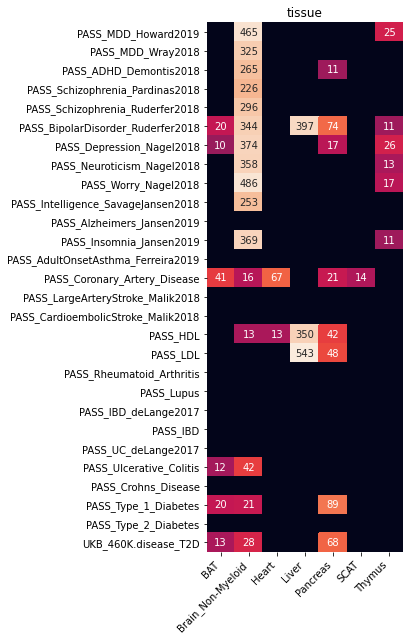

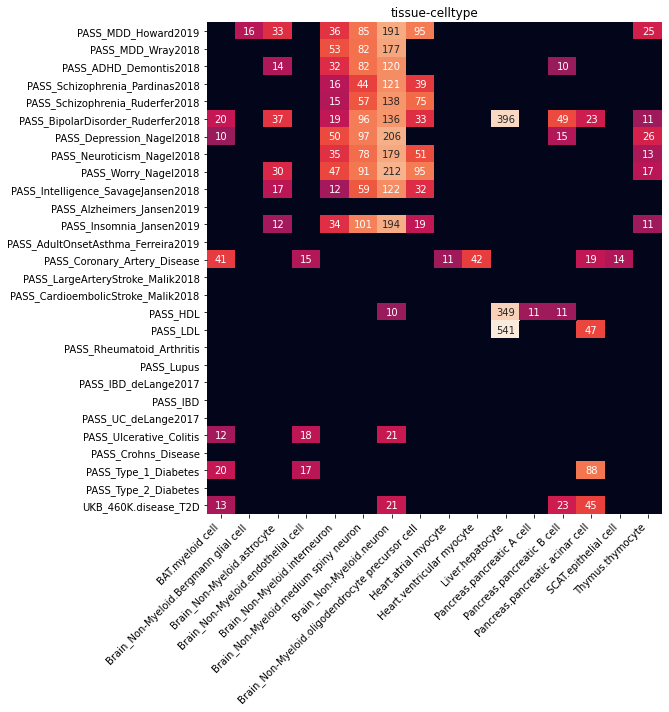

In [68]:
def num2str(x):
    if x>1000:
        return '%0.1fk'%(x/1000)
    elif x>0:
        return '%d'%x
    else:
        return ''
    
for term in dic_assoc.keys():

    df_plot = dic_assoc[term].copy()
    df_plot = df_plot.loc[df_plot.max(axis=1)>10]
    df_plot = df_plot.T
    df_plot[df_plot<10] = 0
    
    mat_annot = np.zeros(df_plot.shape, dtype=object)
    for i_col,col in enumerate(df_plot.columns):
        mat_annot[:,i_col] = [num2str(x) for x in df_plot[col].values]
    df_plot = np.log10(df_plot+1)
    
    plt.figure(figsize=[0.4*df_plot.shape[1]+3, 0.25*df_plot.shape[0]+2+1*('tissue-celltype' in term)])
    sns.heatmap(df_plot, annot=mat_annot, fmt='s', cbar=False)
    plt.xticks(np.arange(df_plot.shape[1])+0.5, df_plot.columns, rotation=45, ha='right')
    plt.title(term)
    plt.tight_layout()
    plt.show()

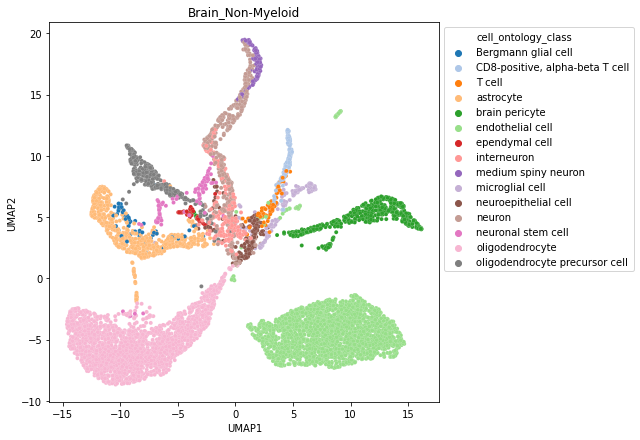

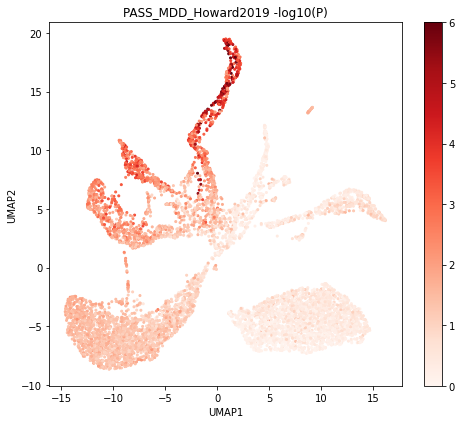

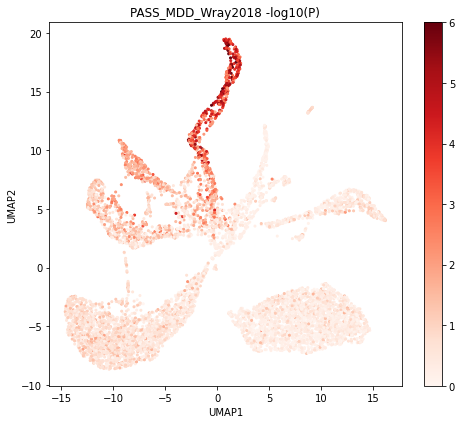

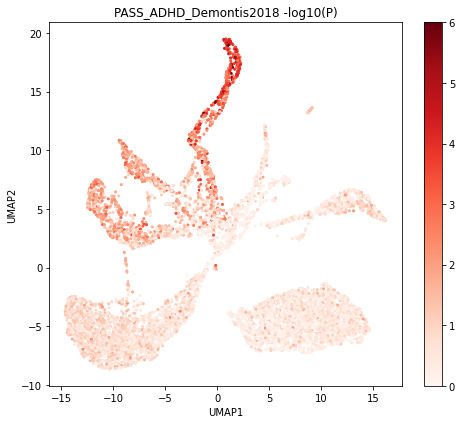

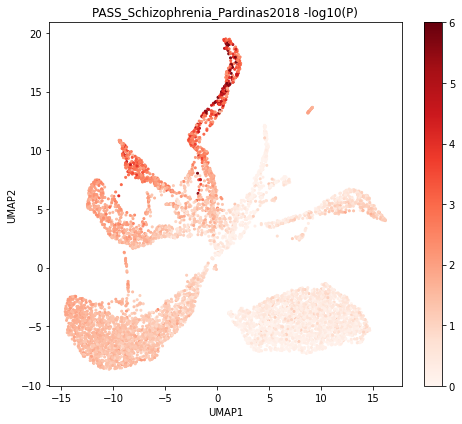

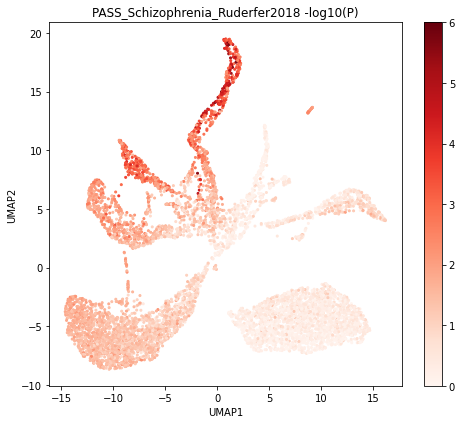

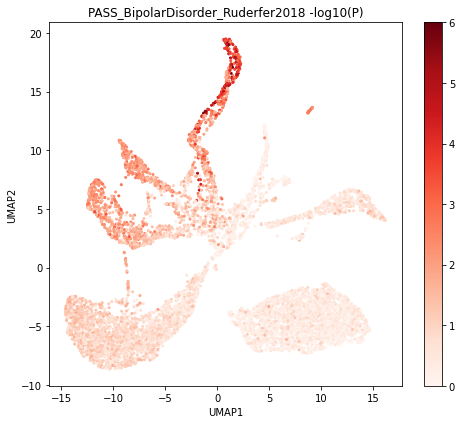

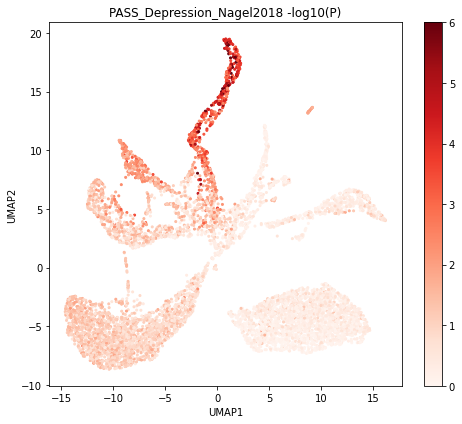

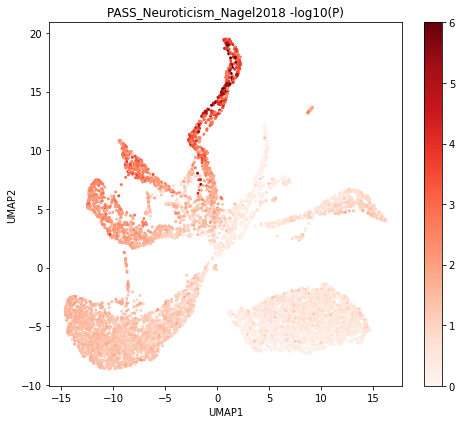

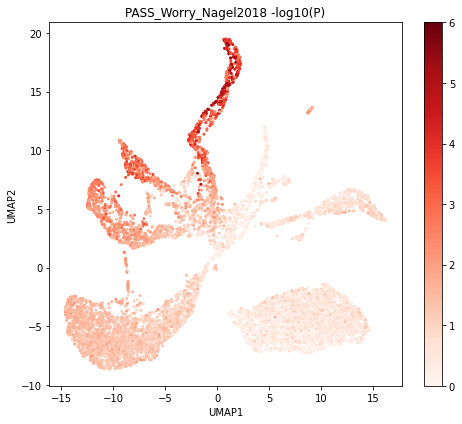

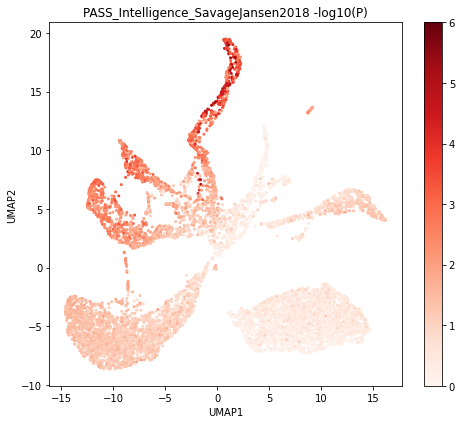

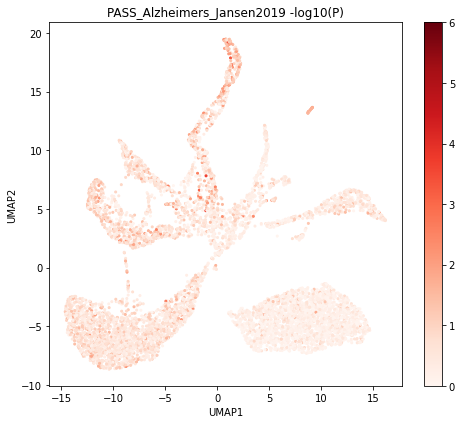

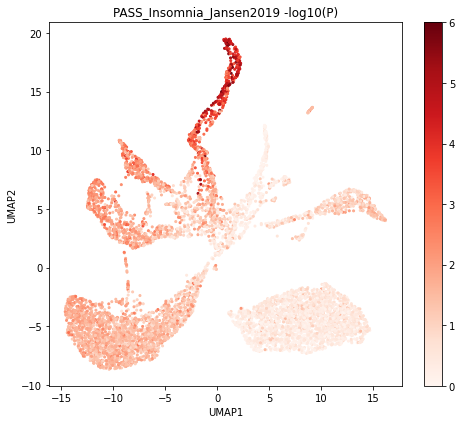

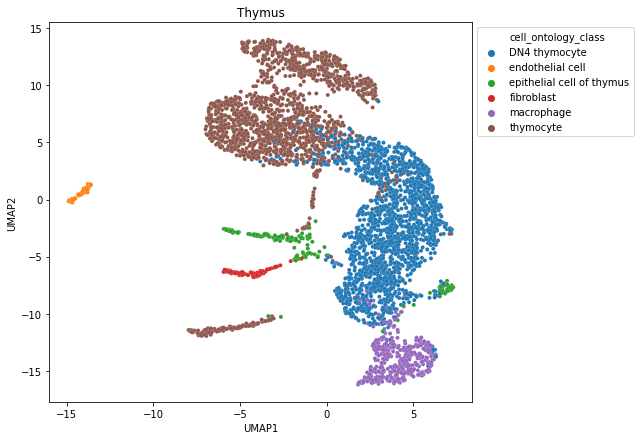

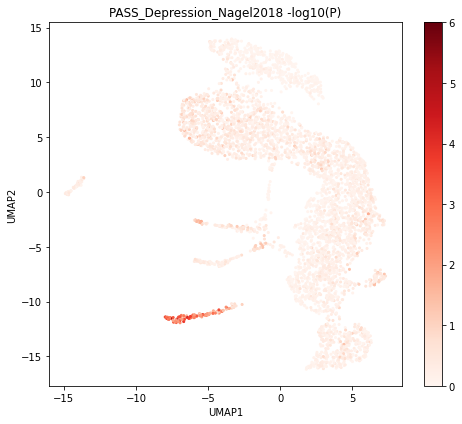

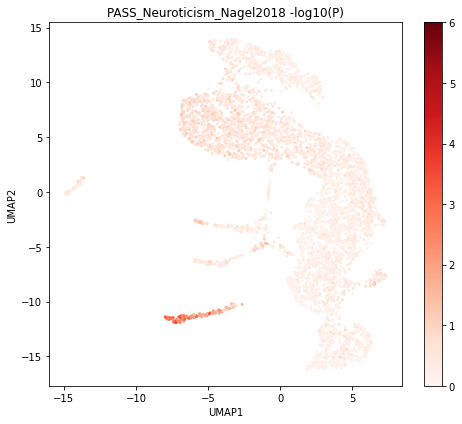

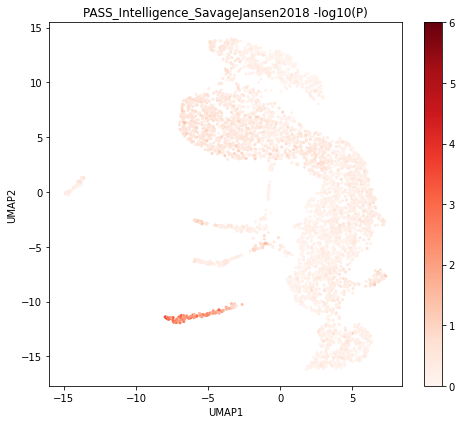

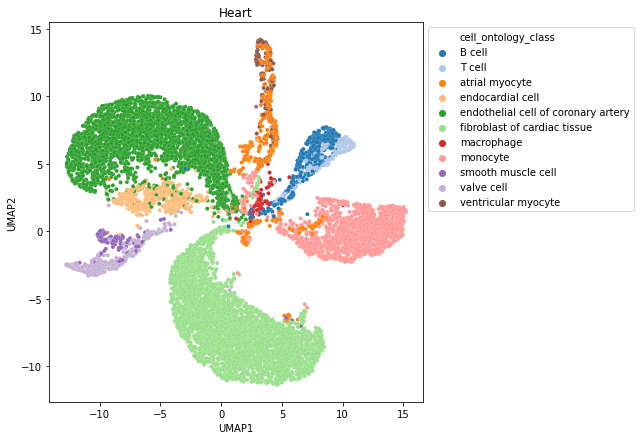

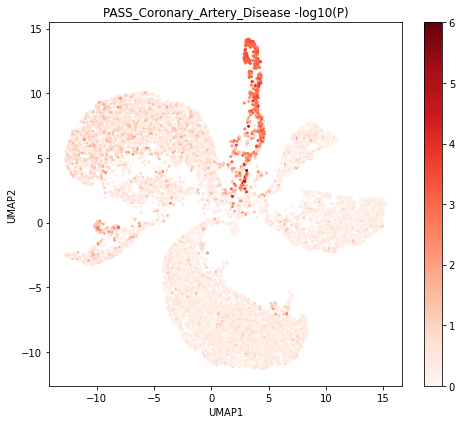

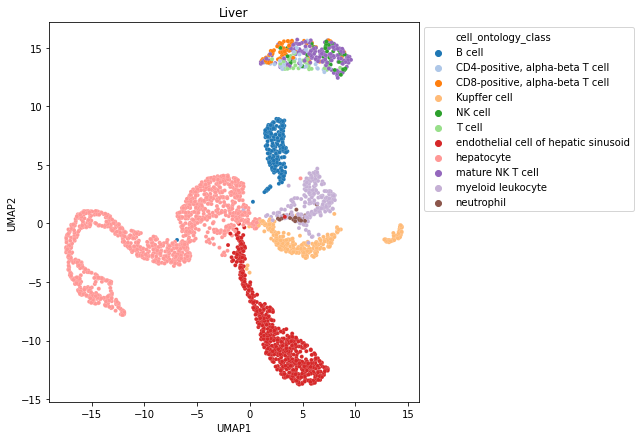

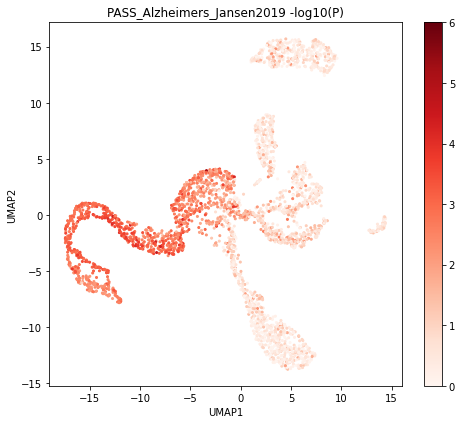

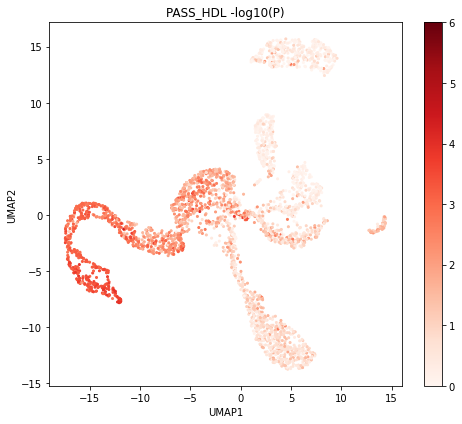

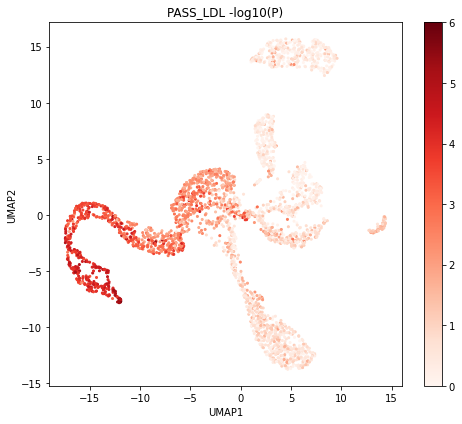

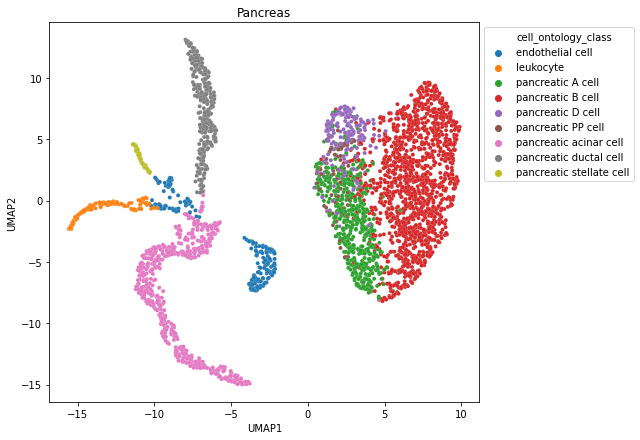

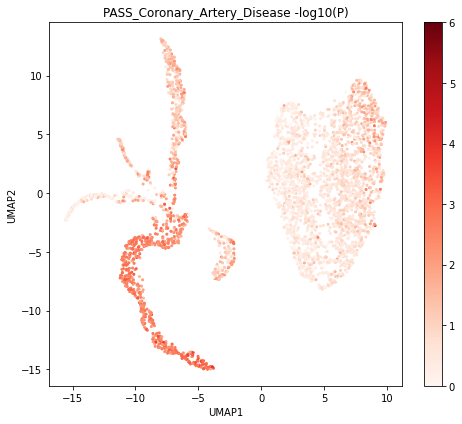

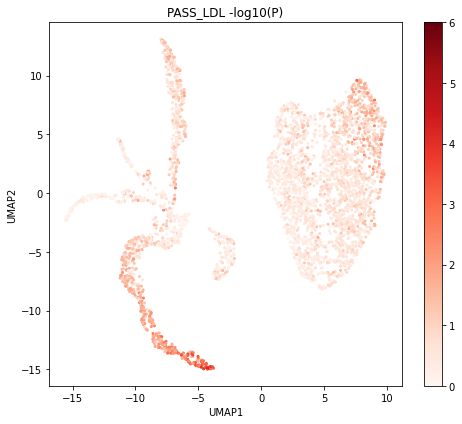

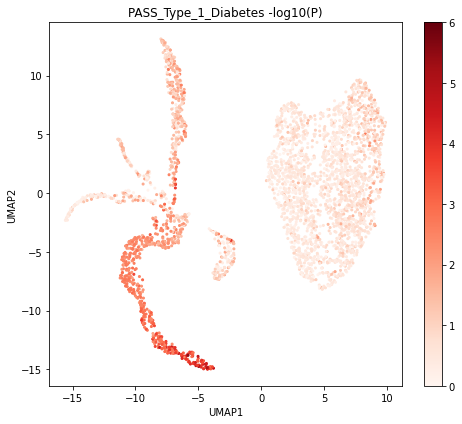

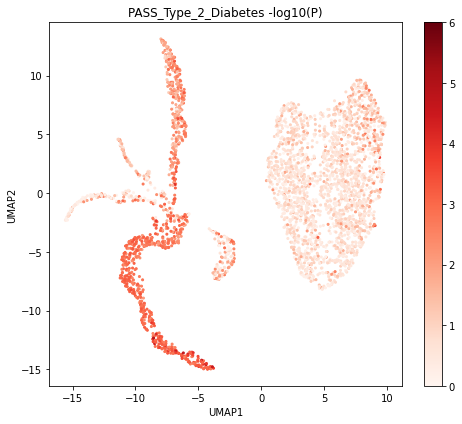

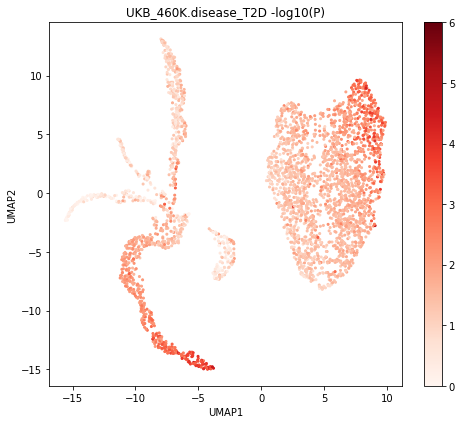

In [78]:
plot_list = [['Brain_Non-Myeloid', 'PASS_MDD_Howard2019'],
             ['Brain_Non-Myeloid', 'PASS_MDD_Wray2018'],
             ['Brain_Non-Myeloid', 'PASS_ADHD_Demontis2018'],
             ['Brain_Non-Myeloid', 'PASS_Schizophrenia_Pardinas2018'],
             ['Brain_Non-Myeloid', 'PASS_Schizophrenia_Ruderfer2018'],
             ['Brain_Non-Myeloid', 'PASS_BipolarDisorder_Ruderfer2018'],
             ['Brain_Non-Myeloid', 'PASS_Depression_Nagel2018'],
             ['Brain_Non-Myeloid', 'PASS_Neuroticism_Nagel2018'],
             ['Brain_Non-Myeloid', 'PASS_Worry_Nagel2018'],
             ['Brain_Non-Myeloid', 'PASS_Intelligence_SavageJansen2018'],
             ['Brain_Non-Myeloid', 'PASS_Alzheimers_Jansen2019'],
             ['Brain_Non-Myeloid', 'PASS_Insomnia_Jansen2019'],
             ['Thymus', 'PASS_Depression_Nagel2018'],
             ['Thymus', 'PASS_Neuroticism_Nagel2018'],
             ['Thymus', 'PASS_Intelligence_SavageJansen2018'],
             ['Heart', 'PASS_Coronary_Artery_Disease'],
             ['Liver', 'PASS_Alzheimers_Jansen2019'],
             ['Liver', 'PASS_HDL'],
             ['Liver', 'PASS_LDL'],
             ['Pancreas', 'PASS_Coronary_Artery_Disease'],
             ['Pancreas', 'PASS_LDL'],
             ['Pancreas', 'PASS_Type_1_Diabetes'],
             ['Pancreas', 'PASS_Type_2_Diabetes'],
             ['Pancreas', 'UKB_460K.disease_T2D']]

tissue_plot = []
for tissue,trait in plot_list:
    
    temp_df = pd.DataFrame(index=data_facs_ct.obs.index)
    temp_df['trs_ep'] = data=dic_trs['%s;trs_ep'%(trait)]
    temp_df['trs_ez'] = data=dic_trs['%s;trs_ez'%(trait)]
    
    df_plot = pd.DataFrame(index=dic_data_facs[tissue].obs.index)
    df_plot['UMAP1'] = dic_data_facs[tissue].obsm['X_umap'][:,0]
    df_plot['UMAP2'] = dic_data_facs[tissue].obsm['X_umap'][:,1]
    df_plot['cell_ontology_class'] = dic_data_facs[tissue].obs['cell_ontology_class']
    
    df_plot['trs_ez'] = temp_df.loc[df_plot.index, 'trs_ez']
    df_plot['trs_ep'] = temp_df.loc[df_plot.index, 'trs_ep']
    df_plot['trs_nlog10p'] = -np.log10(df_plot['trs_ep'])
    
    temp_df = df_plot.groupby('cell_ontology_class').agg({'trs_ez':len})
    celltype_list = list(temp_df.index[temp_df['trs_ez']>25])
    celltype_list.sort()
    celltype_set = set(celltype_list)
    df_plot = df_plot.loc[[x in celltype_set for x in df_plot['cell_ontology_class']]]
    
    if len(celltype_list)<=10:
        palette='tab10'
    else:
        palette='tab20'
    
    if tissue not in tissue_plot:
        tissue_plot.append(tissue)
        plt.figure(figsize=[9,6])
        sns.scatterplot(data=df_plot, x='UMAP1', y='UMAP2', 
                        hue='cell_ontology_class', hue_order=celltype_list, palette=palette,
                        s=16, linewidth=0.1)
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.tight_layout()
        plt.title(tissue)
        plt.show()
    
    plt.figure(figsize=[7,6])
    plt.scatter(df_plot['UMAP1'], df_plot['UMAP2'], c=df_plot['trs_nlog10p'],
                cmap='Reds', vmin=0, vmax=6, s=4)
    plt.colorbar()
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.title('%s -log10(P)'%trait)
    plt.tight_layout()
    plt.show()
    
#     break
    

### Consistency

In [56]:
# Obtain TRS
dic_trs = {}
start_time = time.time()
    
trait = 'PASS_MDD_Wray2018'
ind_select = (dic_geneset[trait]['fdr'].values<0.1)
gene_list = dic_geneset[trait].index[ind_select]


n_ctrl_list = [1,2,5,10,20]
n_rep = 10
dic_res = {x:[] for x in n_ctrl_list}

for n_ctrl in n_ctrl_list:
    for i_rep in range(n_rep):
        md.score_cell(data_facs_ct, gene_list, suffix='',
                      ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                      n_ctrl=n_ctrl, n_genebin=200,
                      return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], random_seed=i_rep+0, verbose=False)
        v_z1 = data_facs_ct.obs['trs_ez'].values.copy()
        
        md.score_cell(data_facs_ct, gene_list, suffix='',
                      ctrl_opt='mean_match', trs_opt='vst', bc_opt='empi',
                      n_ctrl=n_ctrl, n_genebin=200,
                      return_list=['trs_z', 'trs_tp', 'trs_ep', 'trs_ez'], random_seed=i_rep+1, verbose=False)
        v_z2 = data_facs_ct.obs['trs_ez'].values.copy()
        
        dic_res[n_ctrl].append(np.corrcoef(v_z1,v_z2)[0,1])
        
    print('# n_ctrl=%d, rep=%d/%d, time=%0.1fs'%(n_ctrl, i_rep, n_rep, time.time()-start_time))

# n_ctrl=1, rep=9/10, time=61.7s
# n_ctrl=2, rep=9/10, time=152.4s
# n_ctrl=5, rep=9/10, time=328.9s
# n_ctrl=10, rep=9/10, time=648.0s
# n_ctrl=20, rep=9/10, time=1257.0s


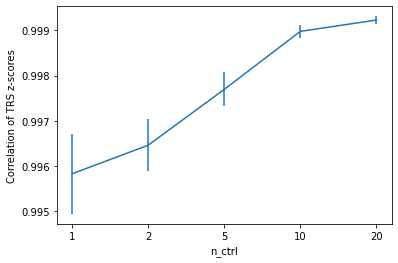

In [80]:
df_plot = pd.DataFrame(index=n_ctrl_list, columns=['mean', 'se'], data=0)
for n_ctrl in n_ctrl_list:
    v_corr = np.array(dic_res[n_ctrl])
    df_plot.loc[n_ctrl] = v_corr.mean(),v_corr.std()/np.sqrt(v_corr.shape[0])
df_plot['loc'] = np.arange(df_plot.shape[0])
plt.figure()
plt.errorbar(df_plot['loc'], df_plot['mean'], yerr=df_plot['se'])
plt.xticks(df_plot['loc'], df_plot.index)
plt.xlabel('n_ctrl')
plt.ylabel('Correlation of TRS z-scores')
plt.show()

### Old code 